# LIME 적용하기


## 데이터 import / summary

In [1]:
import os # 위에껄로 대체가능
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.utils import to_categorical

In [5]:
from tensorflow import keras

In [6]:
from skimage.color import label2rgb # 

In [7]:
import pandas as pd
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # sklearn-image

### function

In [8]:
def scaling_x(img_npy, x_train_mean=False):
    
    
    num_classes=9


    x_train = img_npy.astype('float32') / 255

    # if subtract pixel mean is enabled
    if x_train_mean:
        x_train -= x_train_mean
        
    return x_train


# LIME FOR AV DATA

## Resnet 모델 불러오기

In [9]:
model_path='save_models'
model_file='av11_ResNet44v1_model_no_mean.093.h5'

In [10]:
model=keras.models.load_model(os.path.join(model_path, model_file))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Label 확인하기

In [12]:
# train_ds, test_ds=get_dataset()

# train_ds.class_names

In [13]:
class_names = ['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

#### 아마 위의 순서대로 라벨이 붙을 것.

> load

In [14]:
x_train=np.load('x_train.npy')
x_test=np.load('x_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

> 스케일변환

In [15]:
subtract_pixel_mean = False### model_no_mean은 
num_classes=9


# input image dimensions.
input_shape = x_train.shape[1:]
print('input_shape : ', input_shape)
# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train=y_train.astype('uint8')
y_test=y_test.astype('uint8')
# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape :  (32, 32, 3)
x_train shape: (90000, 32, 32, 3)
90000 train samples
27000 test samples
y_train shape: (90000, 1)


In [16]:
x_train[0][13:16, 13:16, ]

array([[[0.96862745, 0.9411765 , 0.9098039 ],
        [0.9607843 , 0.93333334, 0.9098039 ],
        [0.95686275, 0.92941177, 0.8980392 ]],

       [[0.96862745, 0.9411765 , 0.9098039 ],
        [0.9607843 , 0.93333334, 0.9098039 ],
        [0.9529412 , 0.9254902 , 0.8862745 ]],

       [[0.99607843, 0.96862745, 0.94509804],
        [0.9882353 , 0.95686275, 0.94509804],
        [0.9764706 , 0.9490196 , 0.9098039 ]]], dtype=float32)

### (훈련 전)라벨에는 문제없다.

### 이미지 분류 확인

In [17]:
train_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_train_av'
test_dir='../BDD100K_MOT2020_image/bdd100k/images/track/final_test_av'

### 평가

In [17]:
model.evaluate(x_train, y_train, batch_size=128)

704/704 [==============================] - 14s 13ms/step - loss: 0.2459 - acc: 1.0000


[0.24585869908332825, 1.0]

In [18]:
model.evaluate(x_test, y_test, batch_size=128)

211/211 [==============================] - 3s 14ms/step - loss: 1.6154 - acc: 0.7679


[1.6154298782348633, 0.7678889036178589]

### Scale preprocessing

In [19]:
# np.save('x_train_mean', x_train_mean)

In [35]:
def scaling_x(img_npy, x_train_mean=False):
    
    
    num_classes=9


    x_train = img_npy.astype('float32') / 255

    # if subtract pixel mean is enabled
    if x_train_mean:
        x_train -= x_train_mean
        
    return x_train


### 이미지 분류 개별 확인

In [21]:
# model_path='save_models'
# model_file='av11_ResNet44v1_model_no_mean.123.h5'

# model=keras.models.load_model(os.path.join(model_path, model_file))

In [22]:
manual_index=5

In [23]:
ex_images=[]
for class_name in class_names:
    print(class_name, 'prediction....' f'({class_names.index(class_name)})')
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[manual_index]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))

    ex_images.append(ex_image)


ex_images_scaled=np.array(ex_images)

ex_images_scaled=scaling_x(ex_images_scaled)

> 예측

prediction=model.predict(ex_images_scaled)

top1_class=prediction.argmax(1)

top1_prediction=[]
for i, class_idx in enumerate(top1_class):
    top1_prediction.append(np.round(prediction[i][class_idx], 4))

print(top1_class, top1_prediction)

top1_prediction[5]

top1_prediction[6]

print(top1_prediction[6])

SyntaxError: invalid syntax (<ipython-input-23-406a19acdef1>, line 14)

In [ ]:
fig = plt.figure(figsize=(9,9))

for idx, image in enumerate(ex_images):
    fig.add_subplot(3,3,idx+1)
    plt.axis=('off')
    plt.imshow(image.astype('float32')/255.0)
    plt.title(f'{class_names[idx]}->{class_names[top1_class[idx]]}'+'({})'.format(str(top1_prediction[idx])))
    plt.tight_layout()


# positive example

In [24]:
class_idx=0

In [25]:
class_name=class_names[class_idx]

ex_image_file_list=os.listdir(os.path.join(test_dir, class_name))
np.random.seed(42)
index_arange=np.arange(len(ex_image_file_list))

np.random.shuffle(index_arange)
i=0

In [26]:
index_arange

array([1801, 1190, 1817, ..., 1130, 1294,  860])

range(i:0) : 0 ~ 16


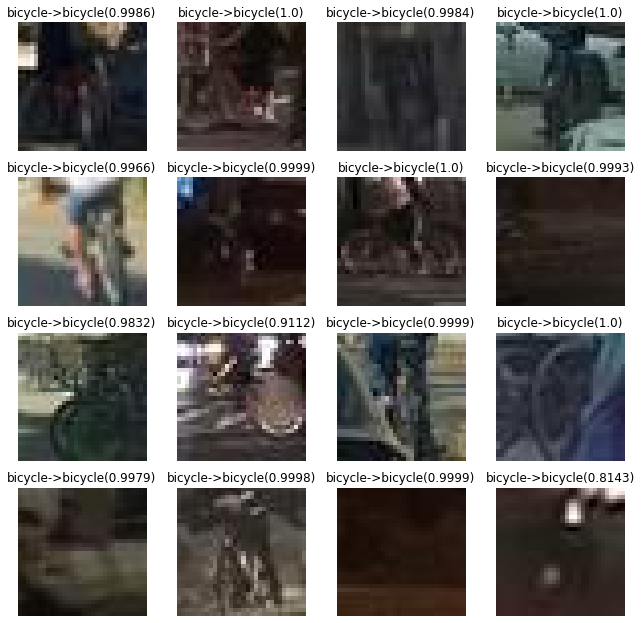

In [27]:
ex_images=[]

# for class_name in class_names:
#     print(class_name, 'prediction....' f'({class_names.index(class_name)})')
#     ex_image_file=os.listdir(os.path.join(test_dir, class_name))[manual_index]
#     ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))

#     ex_images.append(ex_image)

size=16

for idx in index_arange[size*(i):size*(i+1)]:
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file_list[idx]))
    ex_images.append(ex_image)
print('range(i:{}) :'.format(i), f'{size*i} ~ {size*(i+1)}')
ex_images_scaled=np.array(ex_images)
ex_images_scaled=scaling_x(ex_images_scaled)

prediction=model.predict(ex_images_scaled)
top1_class=prediction.argmax(1)
top1_prediction=[]
for i, class_idx in enumerate(top1_class):
    top1_prediction.append(np.round(prediction[i][class_idx], 4))

fig = plt.figure(figsize=(9,9))

for idx, image in enumerate(ex_images):
    ax=fig.add_subplot(4,4,idx+1)
    plt.imshow(image.astype('float32')/255.0)
    plt.title(f'{class_name}->{class_names[top1_class[idx]]}'+'({})'.format(str(top1_prediction[idx])))
    plt.tight_layout()
    ax.set_axis_off() 


In [28]:
# # 이 때 그냥 무작정 잘 맞춘 경우  
# positive_ulti=[30, 27, 27, 31, 33, 28, 28, 29, 33]

# # 이 때 positive는 정확도 높게 맞췄다는 것이 아닌, top1 <-> top2가 비등한 경우이다.
# positive_best=[38, 77, 5, 22, 459, 1, 26, 37, 101]

# # 이 때 negative 역시 너무 차이나서는 안 된다. top1 <-> top2가 비등한 경우이다.
# negative_best=[13, 40, 18, 44, 481, 17, 13, 39, 27]

### LIME 적용 이미지 탐색

In [15]:
# model_regressor를 수정해 설명 모델을 바꿀 수 있고
# segmentation_fn 파라미터를 수정해 이미지분할 알고리즘을 사용할 수 있다.
# 슈퍼픽셀 : 디지털 이미지를 구성하는 점들 중 같은 정보를 가진 점의 집합을 의미한다.

from lime import lime_image # 이미지 모듈
from lime.wrappers.scikit_image import SegmentationAlgorithm # liem이 사용할 수 있게. 

explainer=lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(default), slic, felzenswalb


In [ ]:
full_ex_image_file_list=[]

for class_name in class_names:
    ex_image_file_list=os.listdir(os.path.join(test_dir, class_name))
    full_ex_image_file_list.append(ex_image_file_list)

In [38]:
pick_point=1

size=30

In [39]:
compact=5
segments=50
sigma=0.5

sample_idx=5
segmenter=SegmentationAlgorithm('slic', 
                               n_segments=segments, #이미지 분할 조각 개수
                               compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                               sigma=sigma) # 스무딩 역할, 0과 1 사이의 float


# ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
# ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
# ex_image_scaled=scaling_x(ex_image, x_train_mean)

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

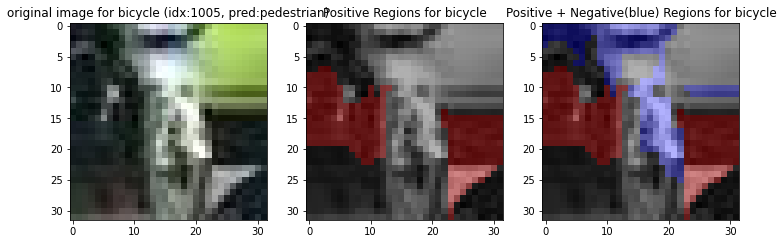

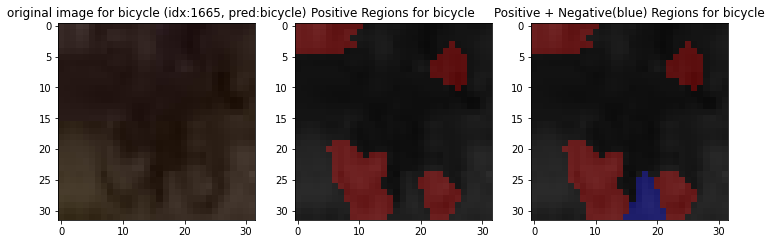

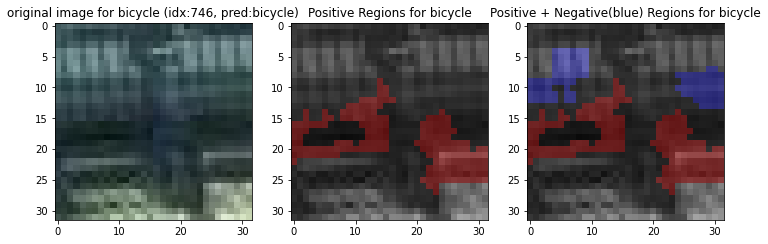

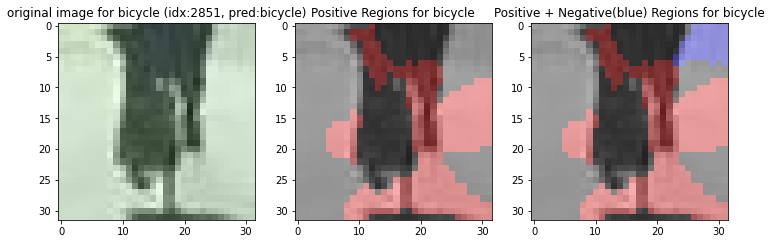

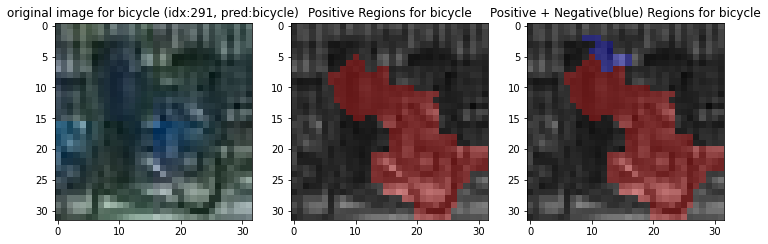

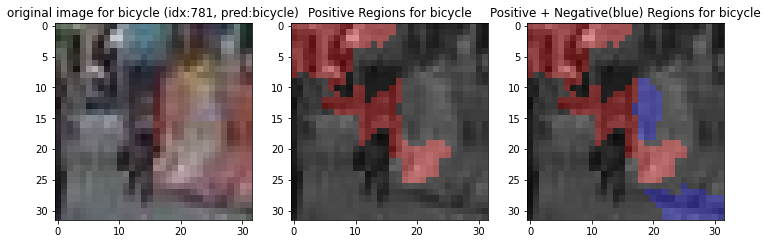

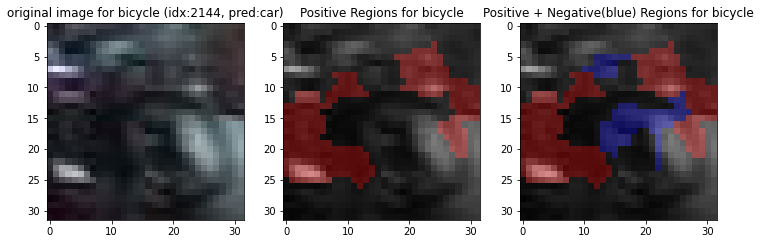

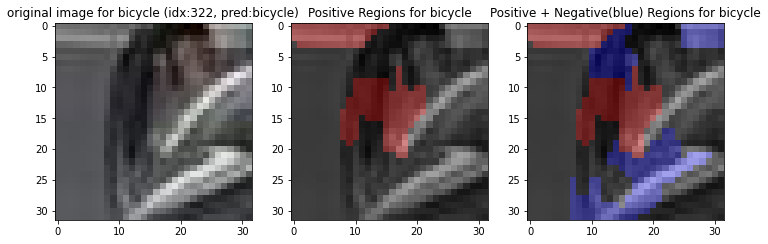

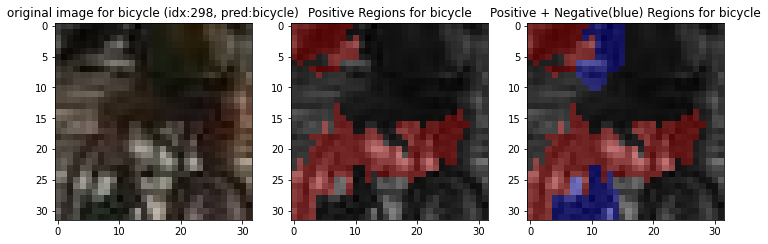

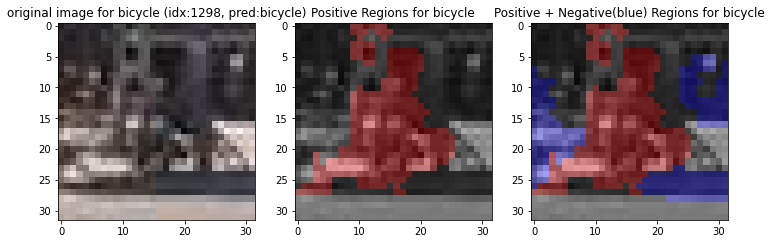

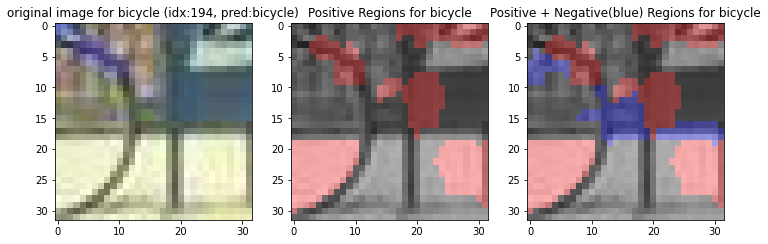

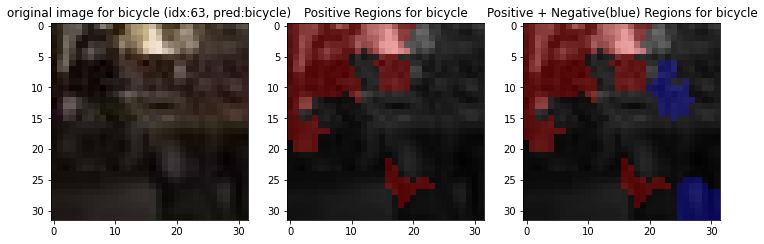

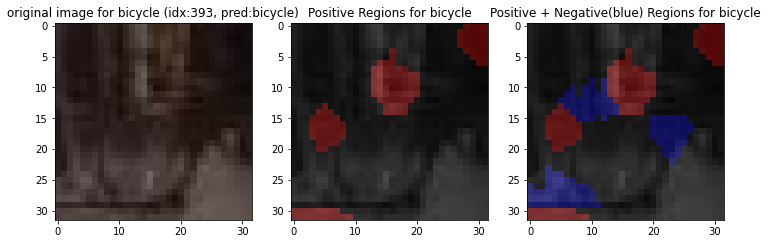

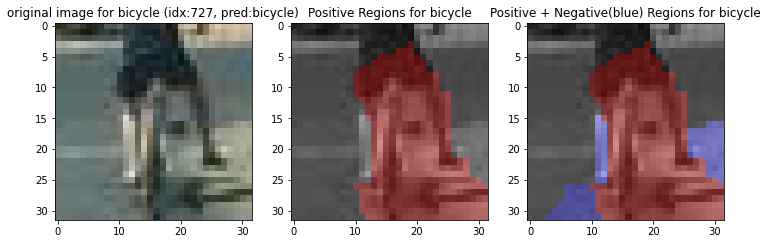

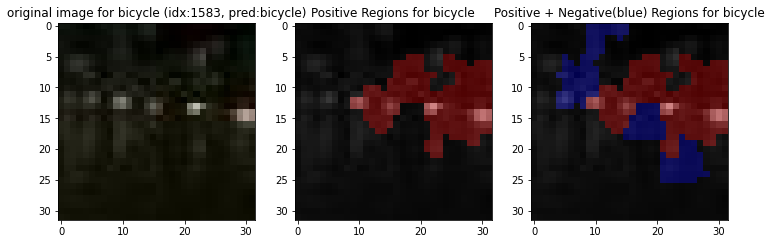

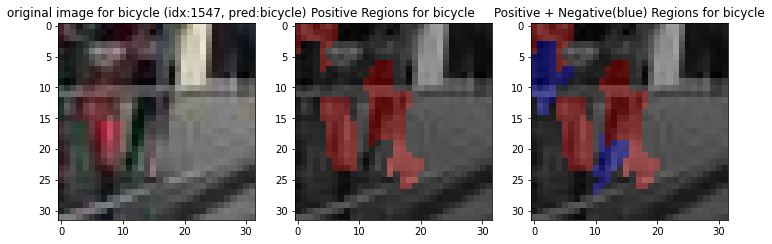

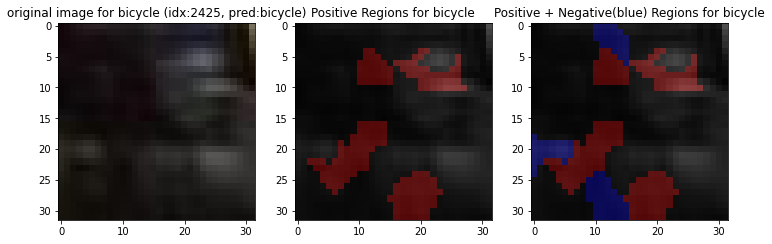

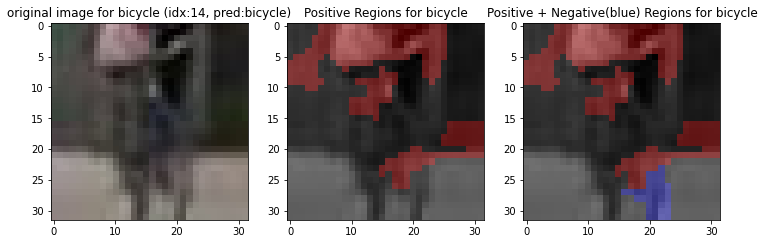

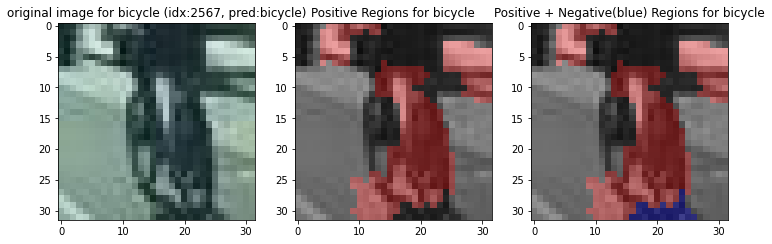

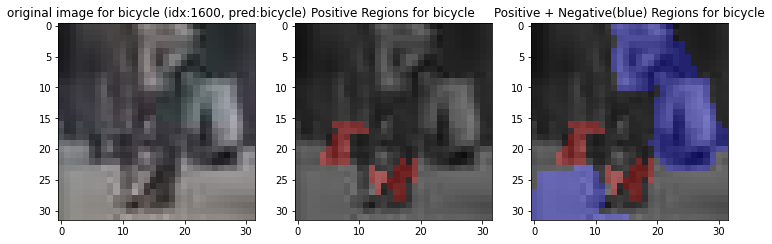

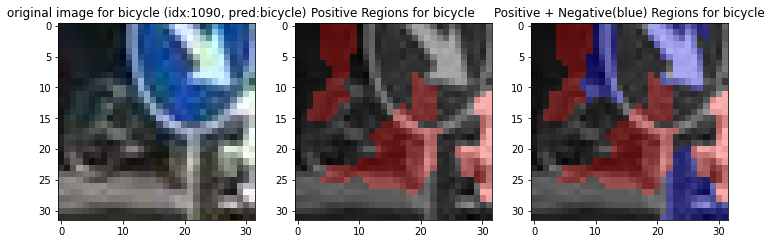

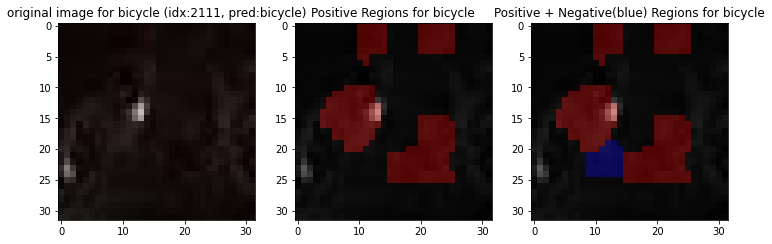

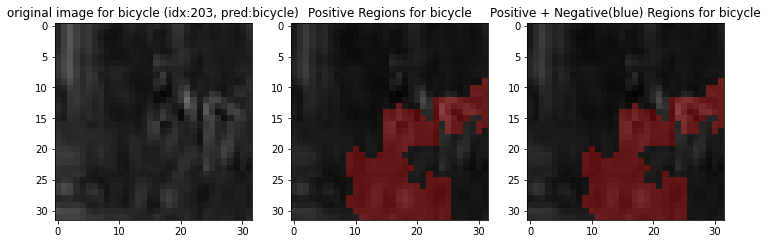

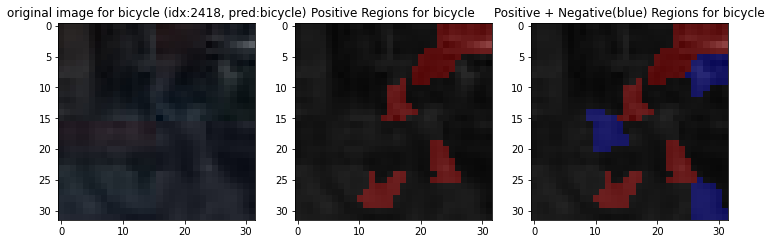

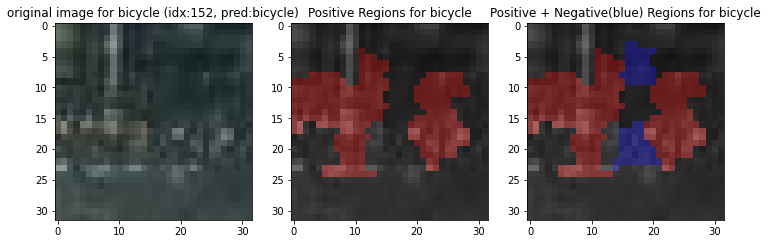

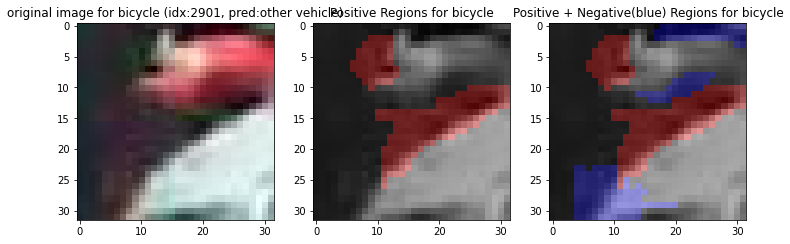

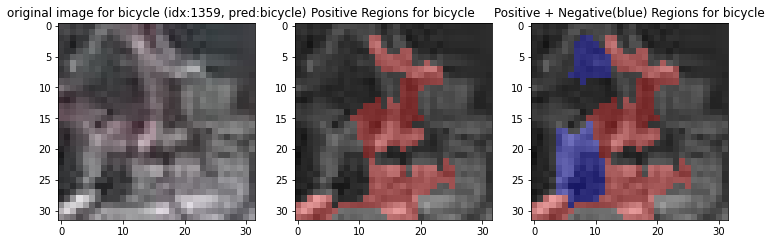

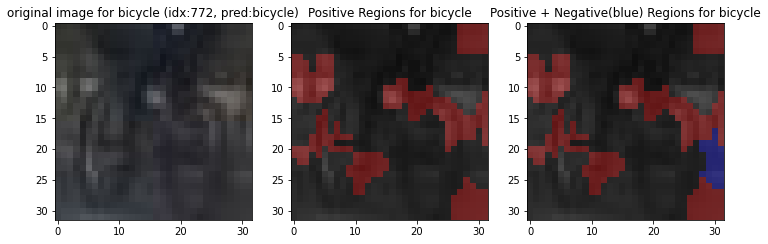

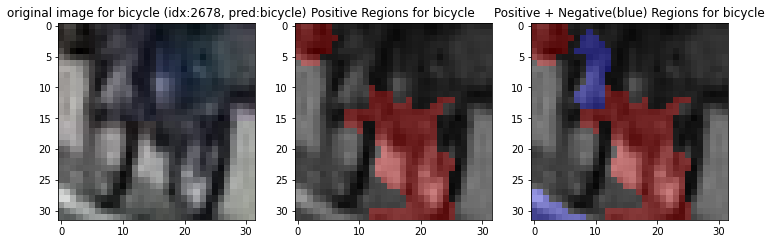

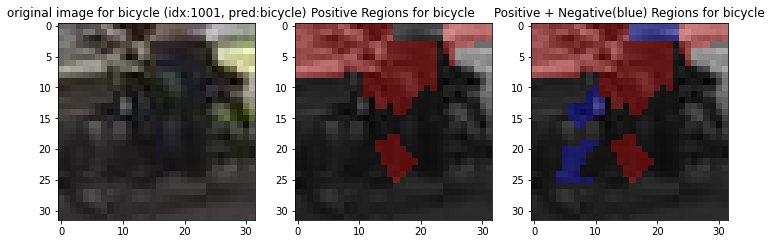

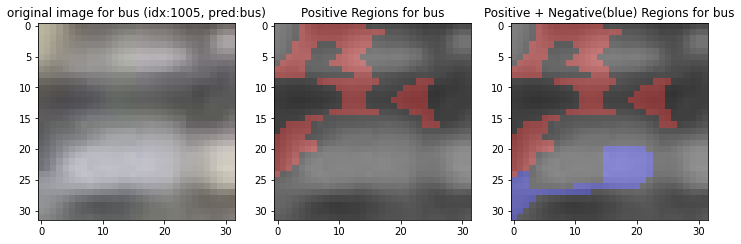

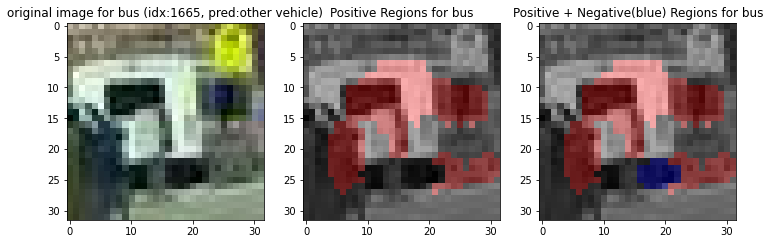

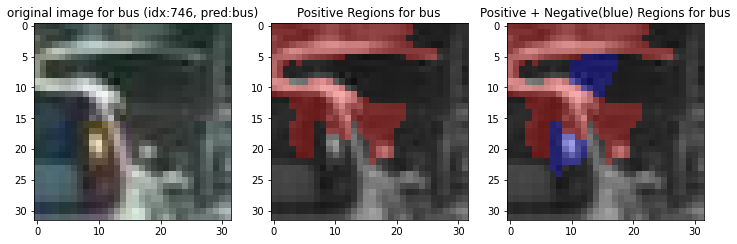

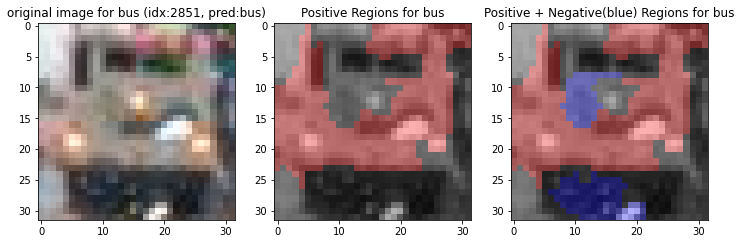

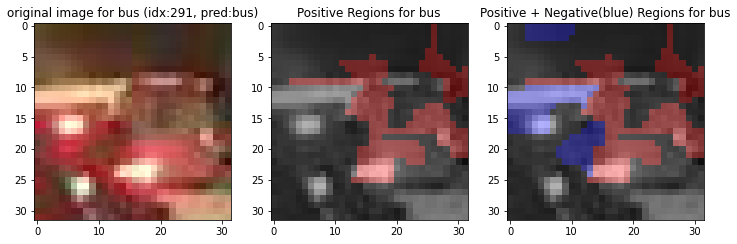

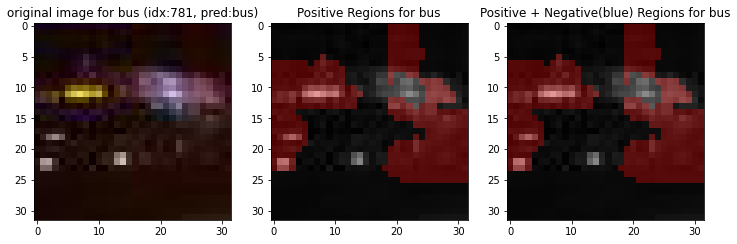

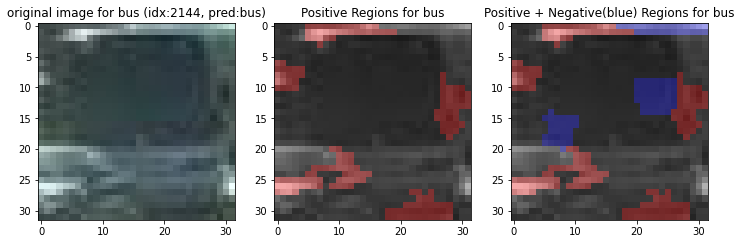

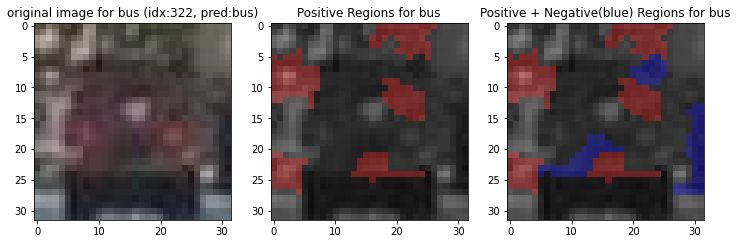

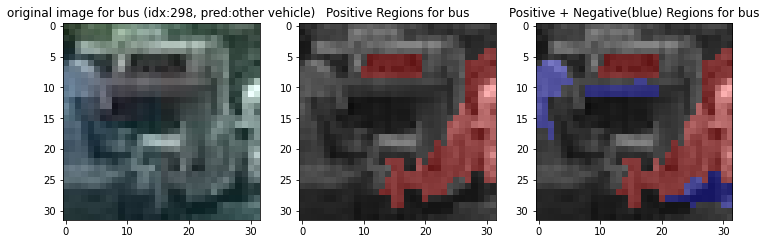

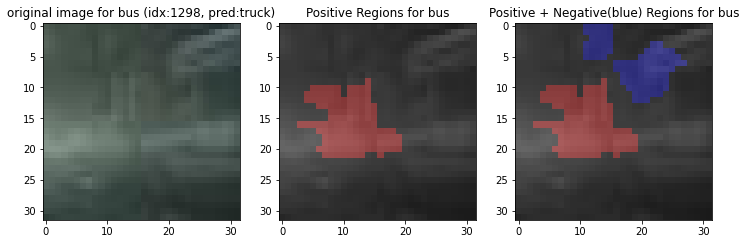

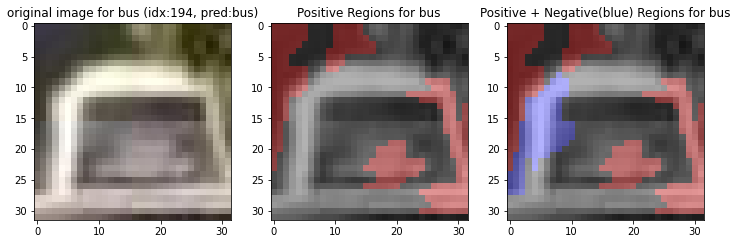

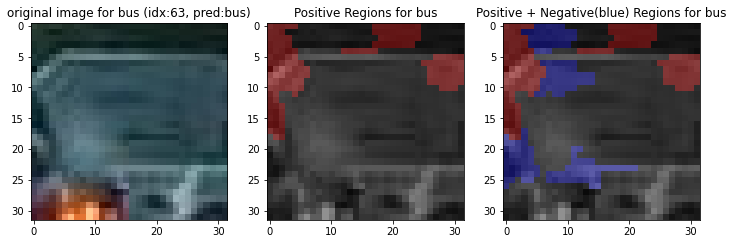

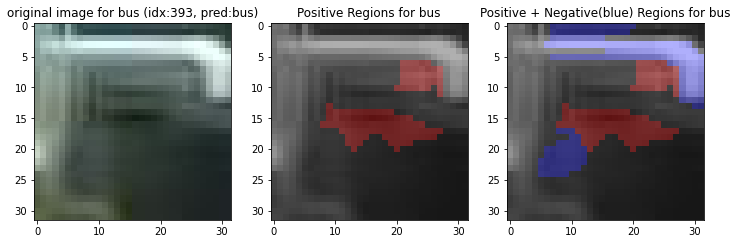

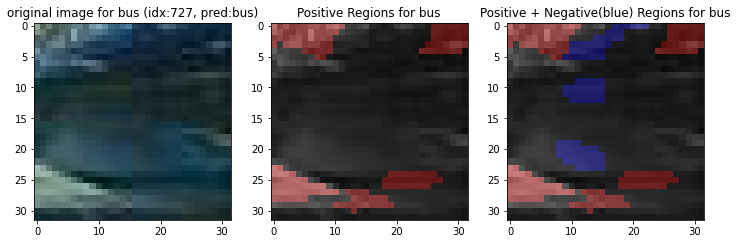

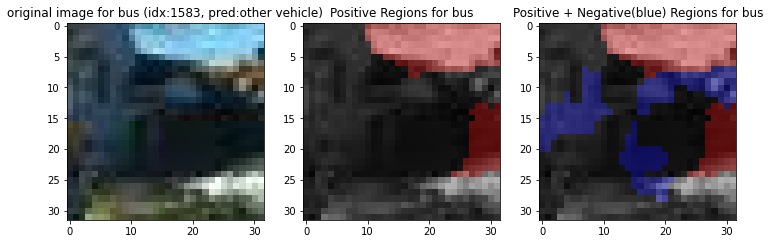

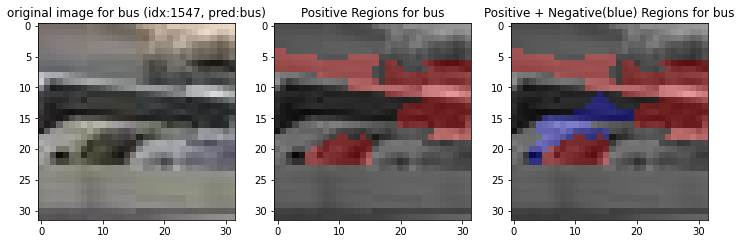

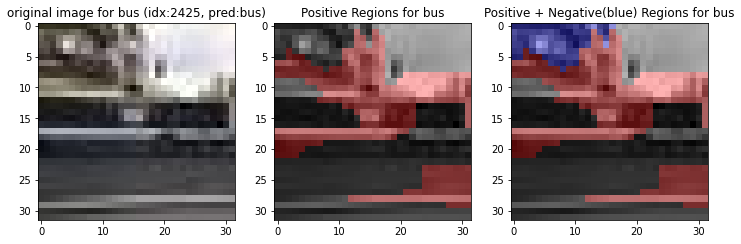

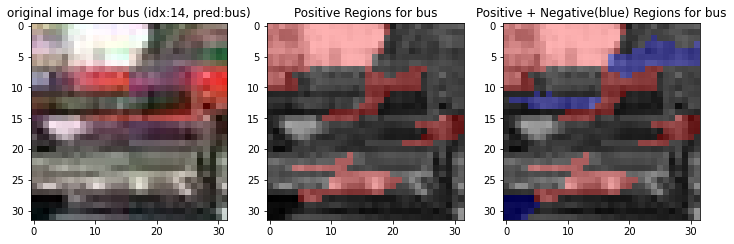

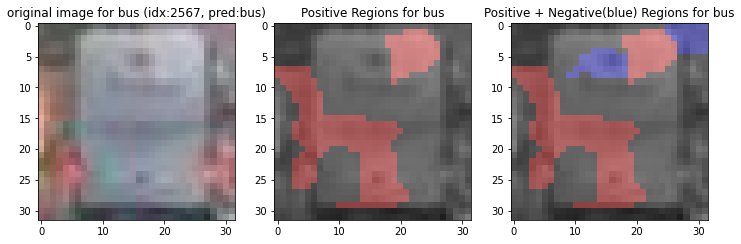

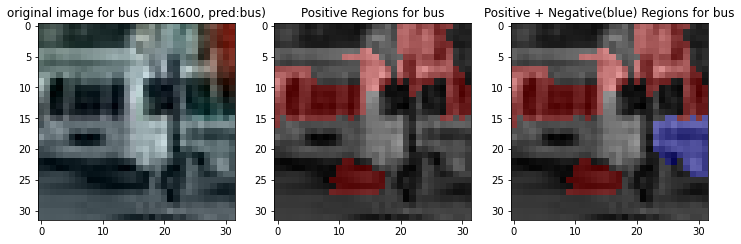

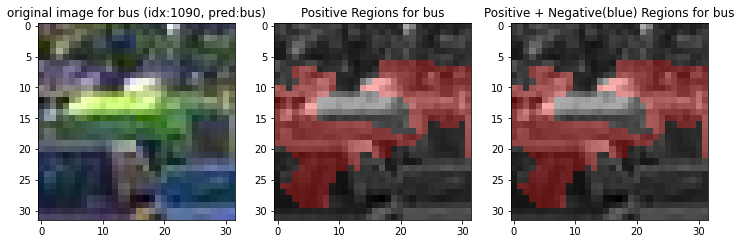

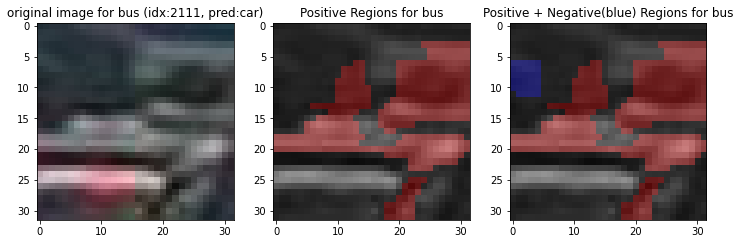

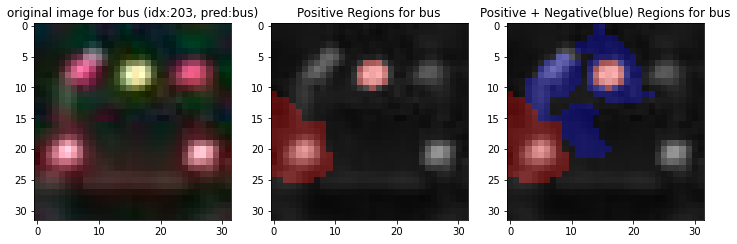

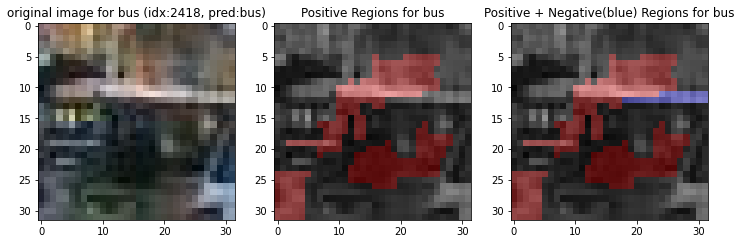

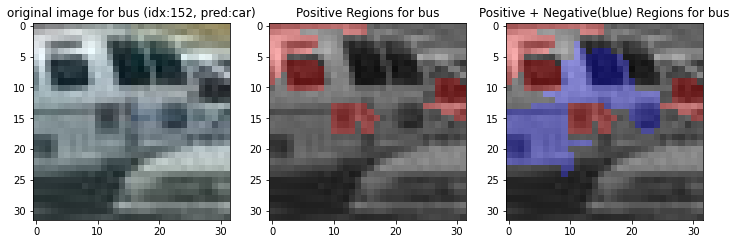

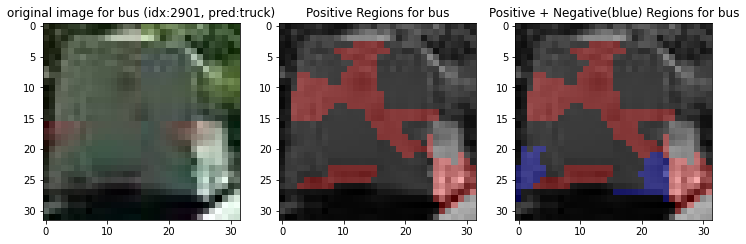

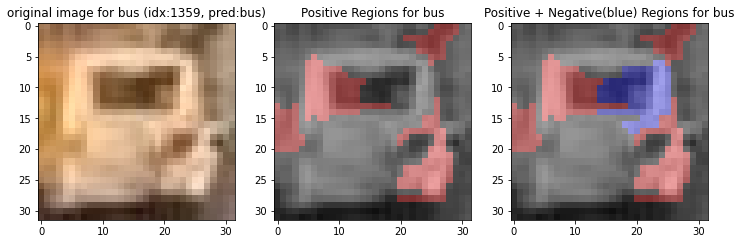

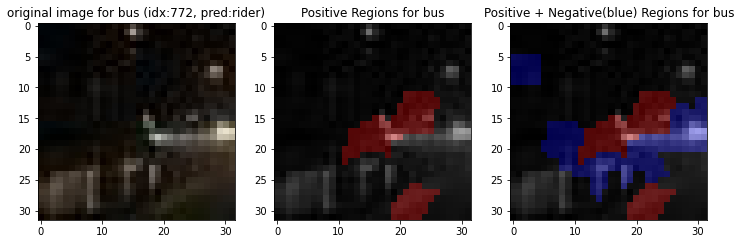

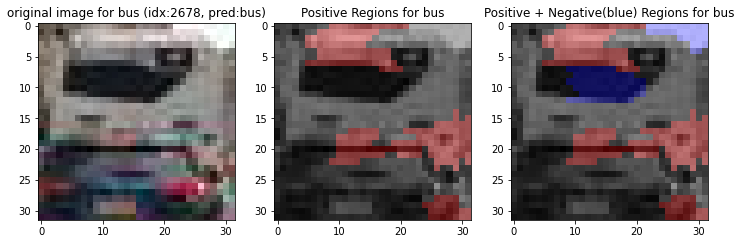

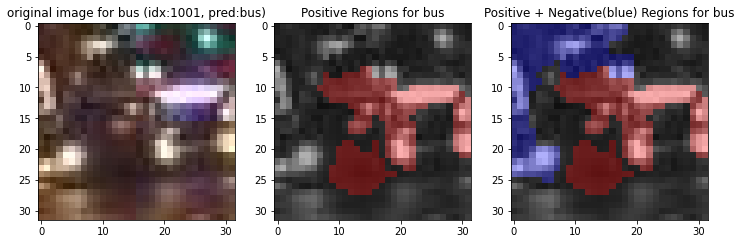

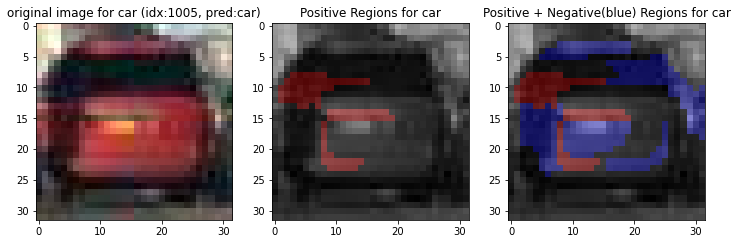

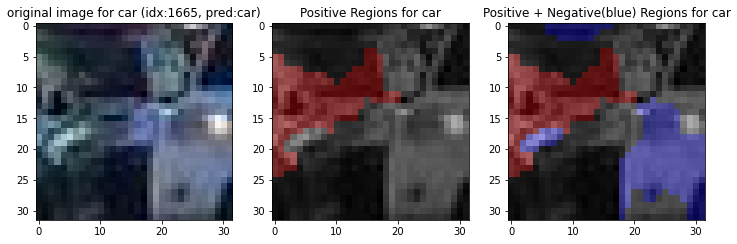

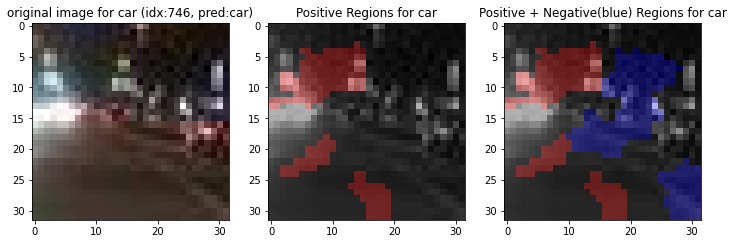

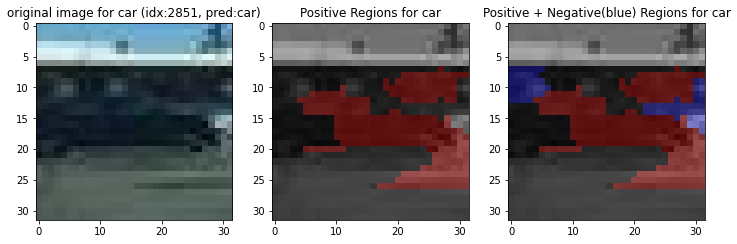

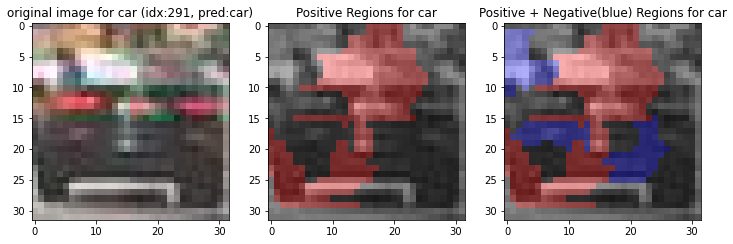

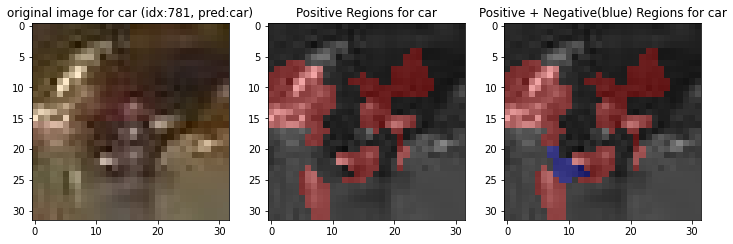

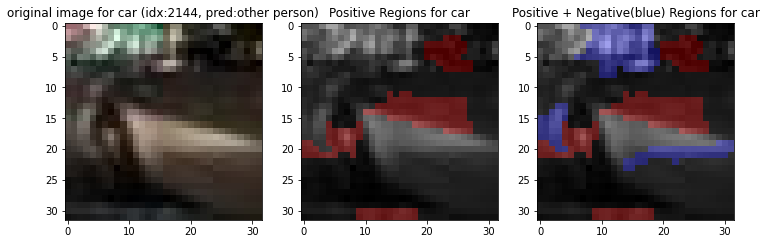

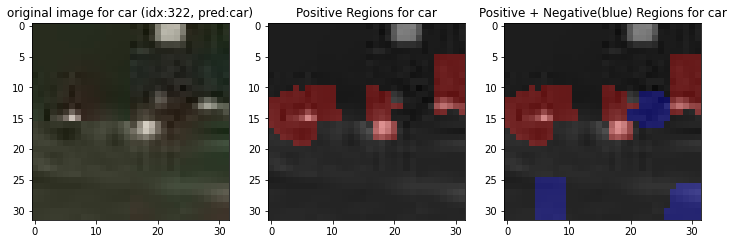

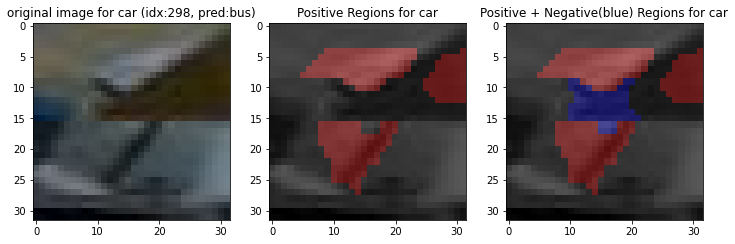

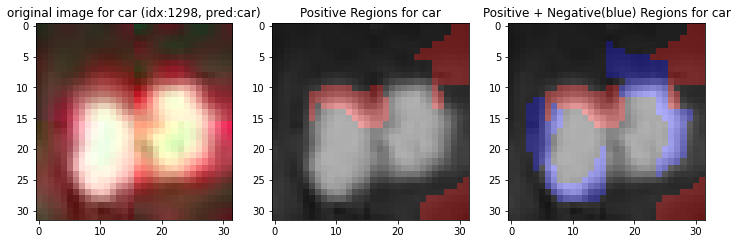

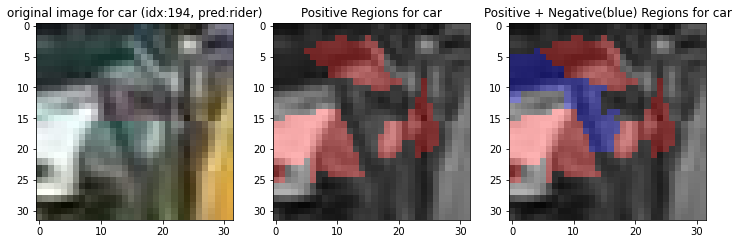

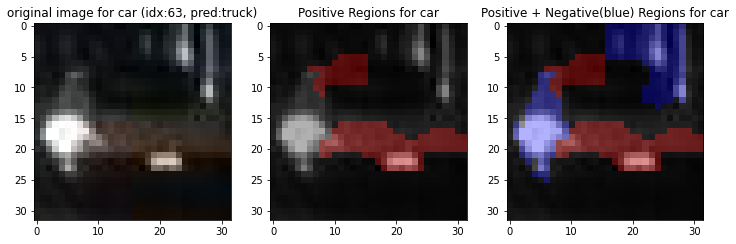

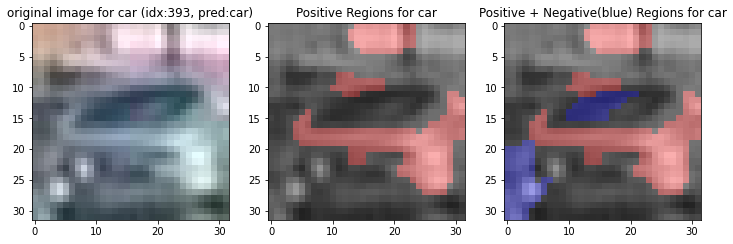

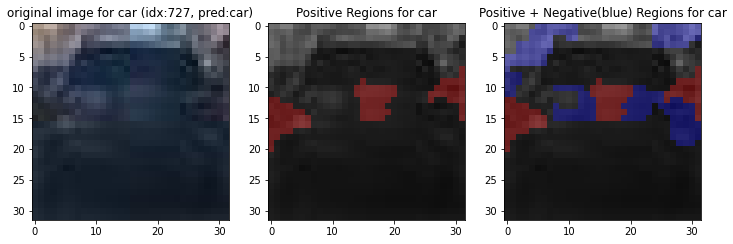

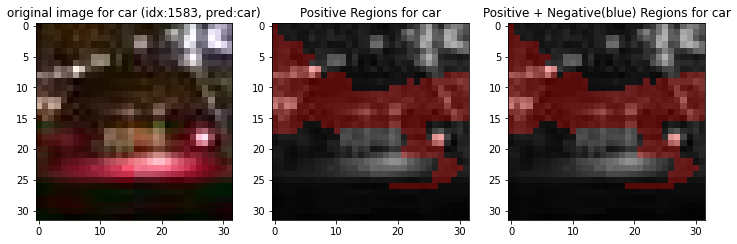

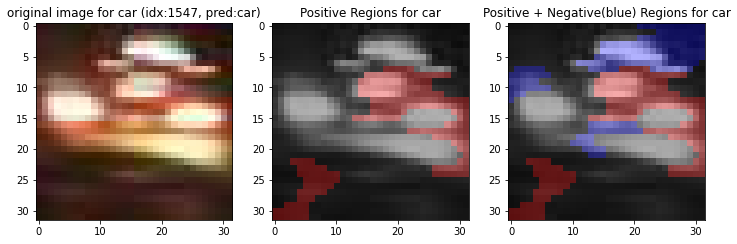

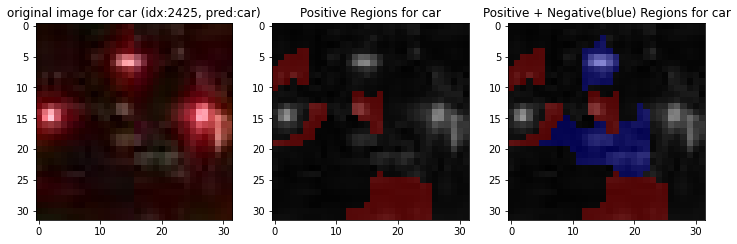

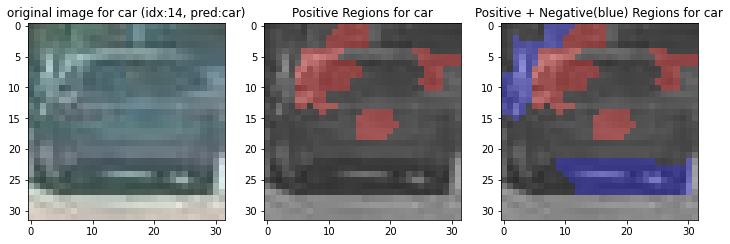

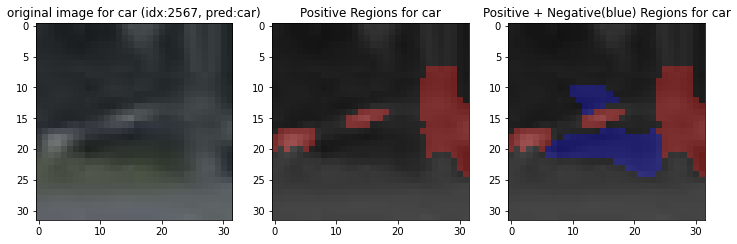

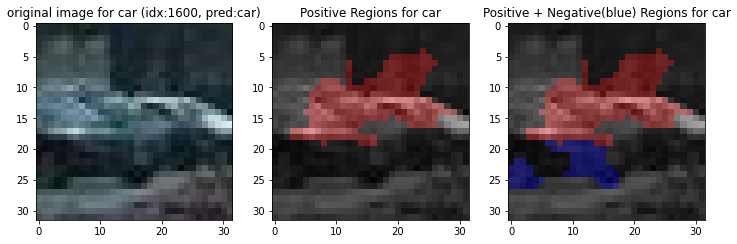

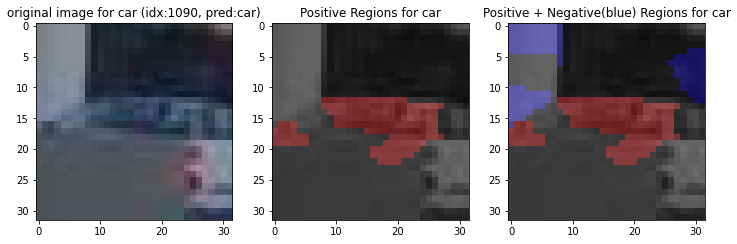

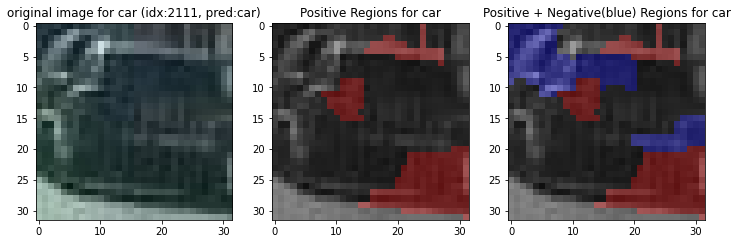

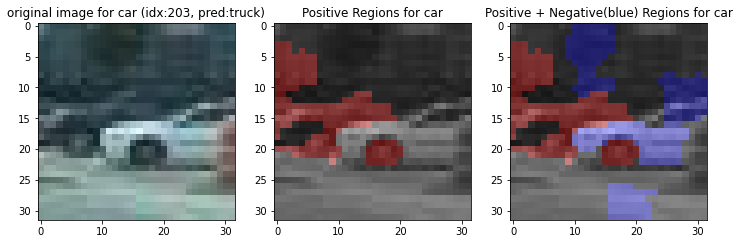

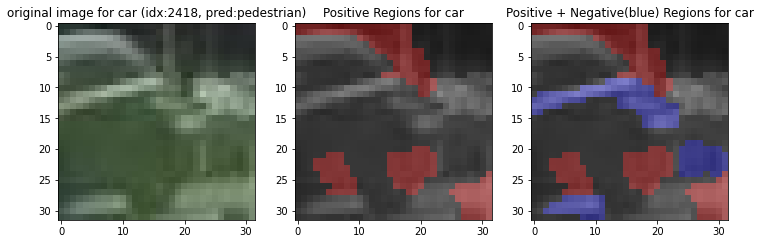

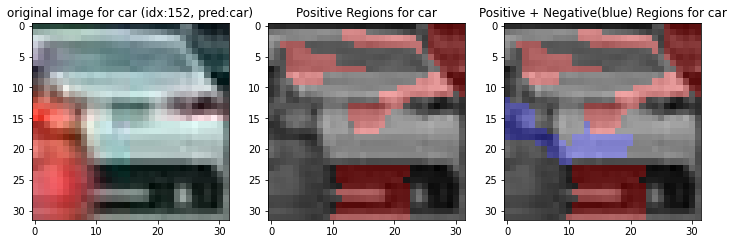

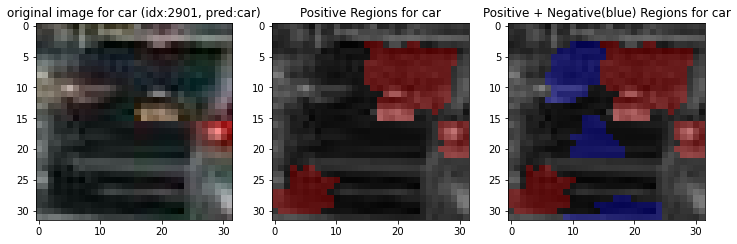

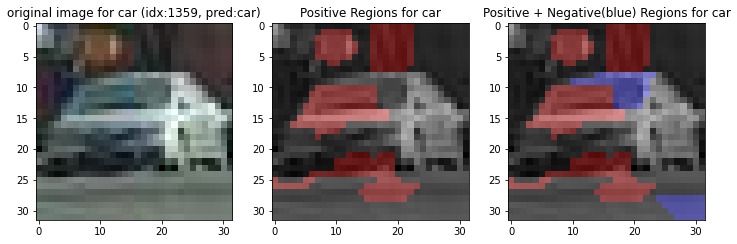

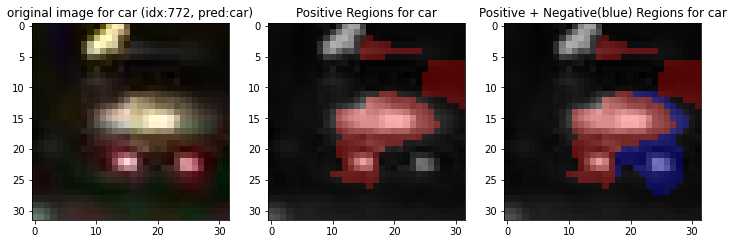

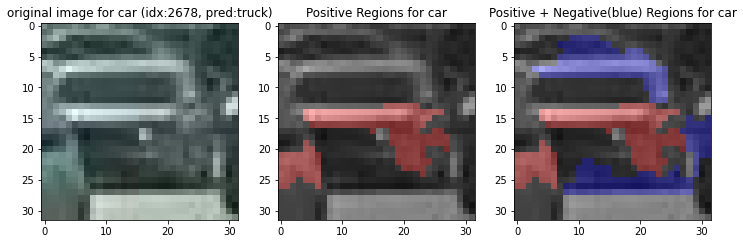

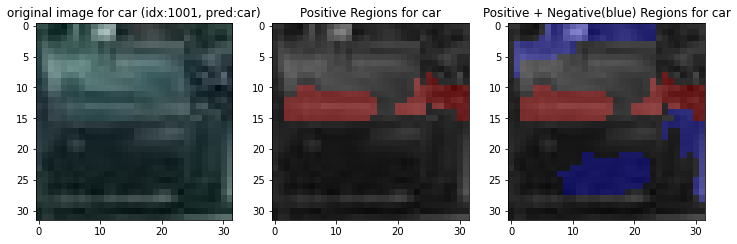

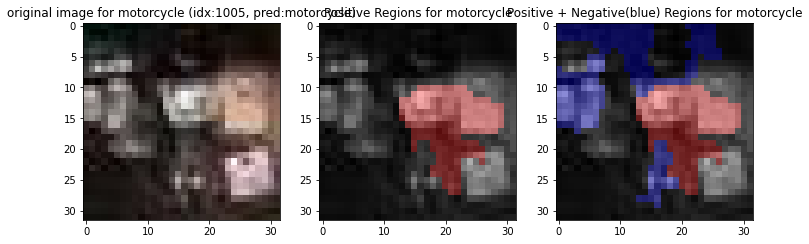

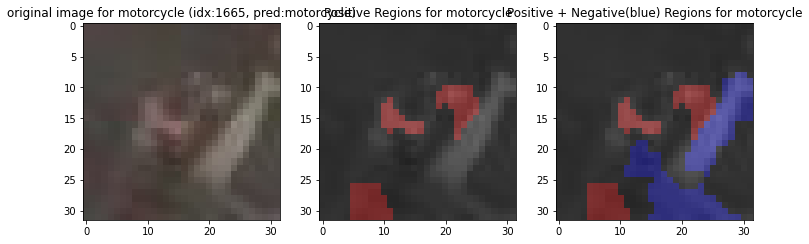

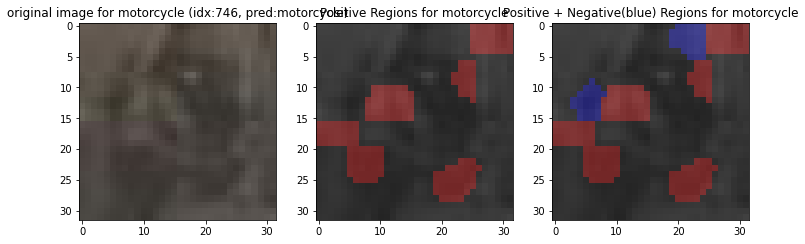

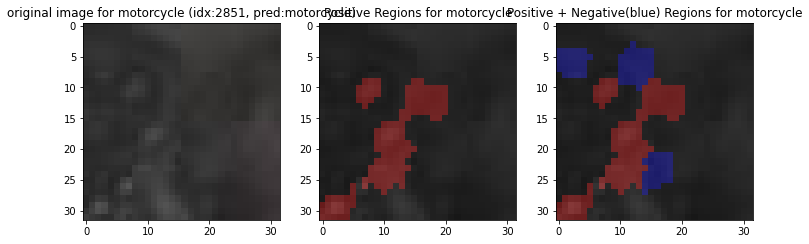

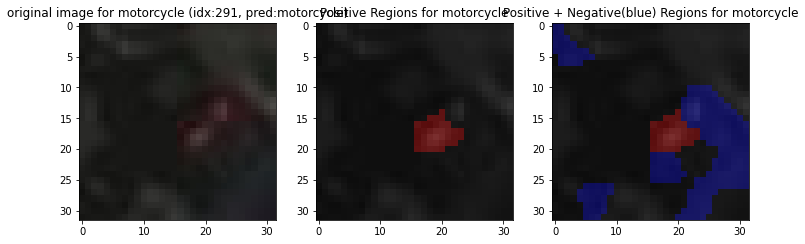

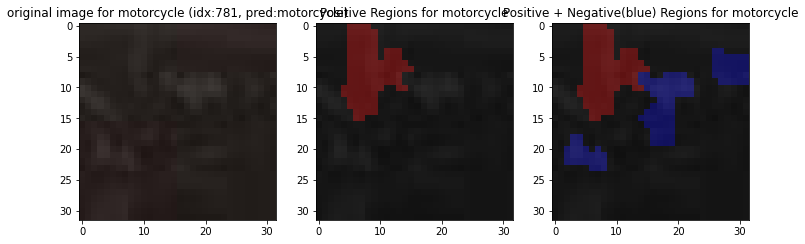

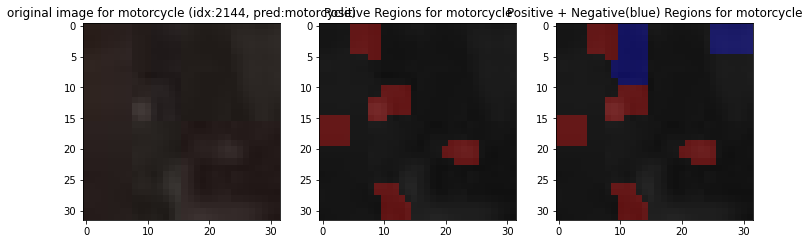

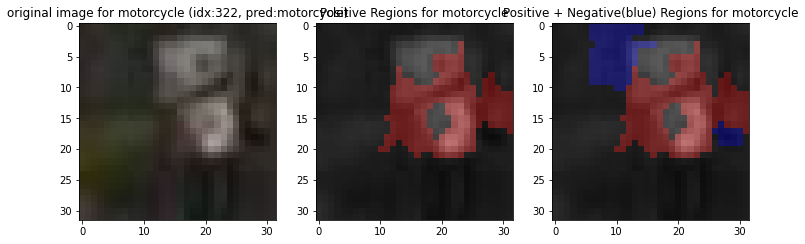

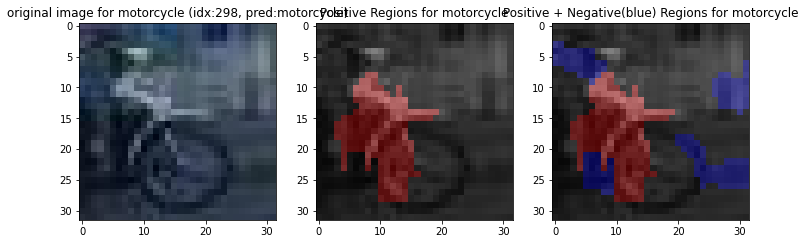

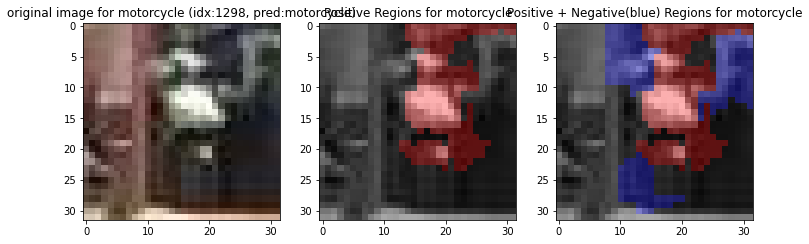

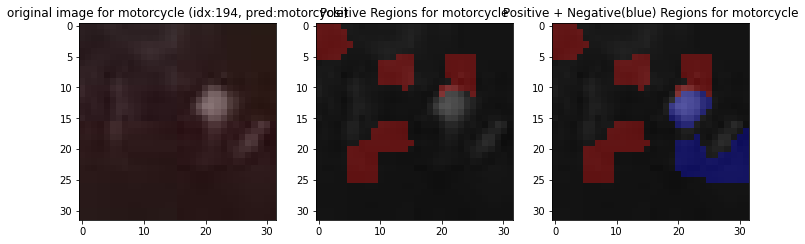

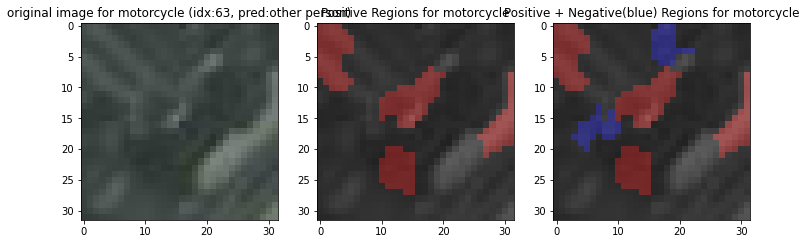

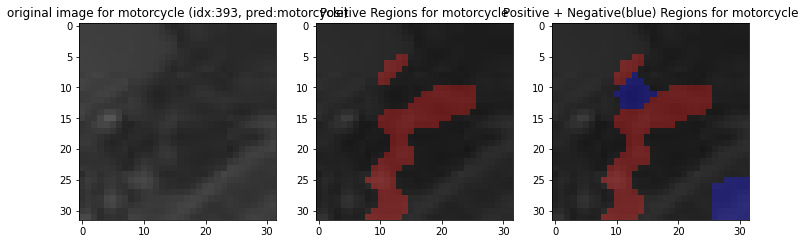

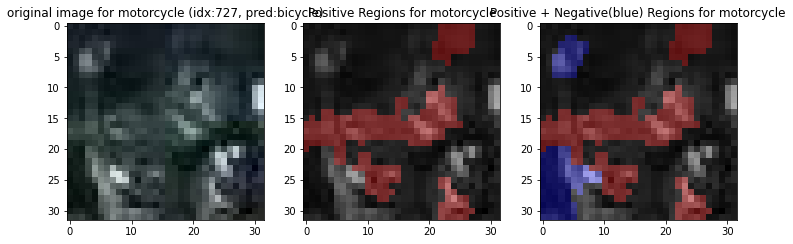

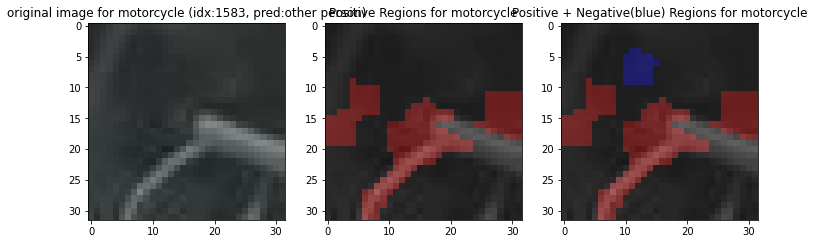

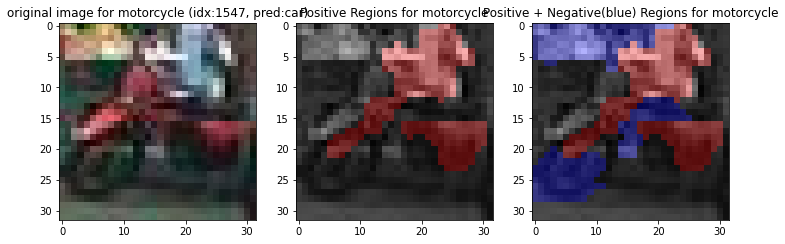

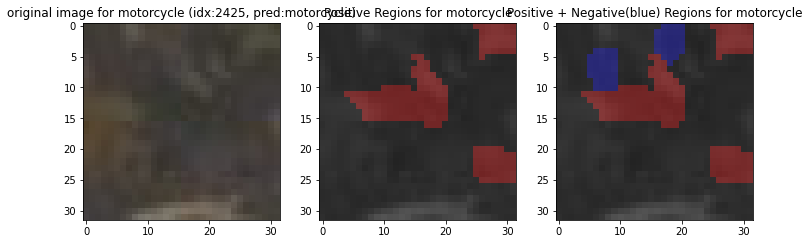

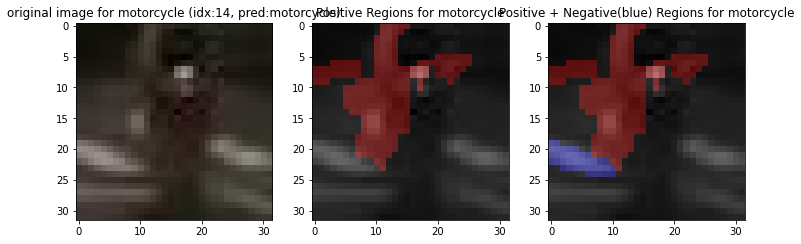

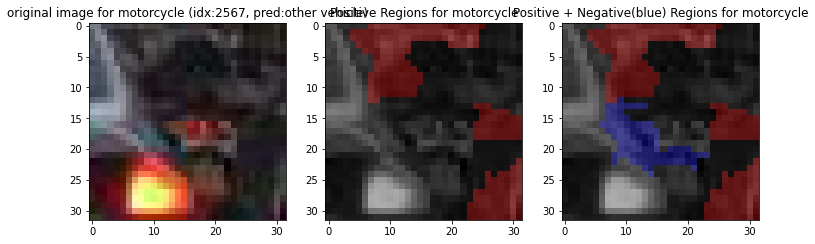

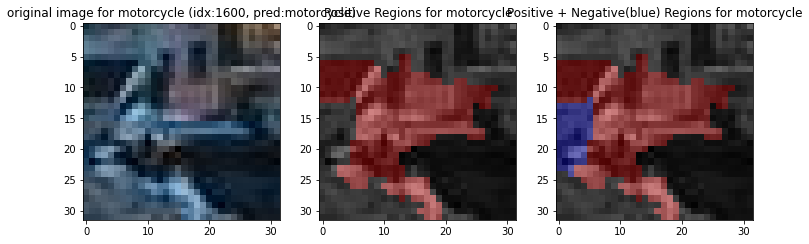

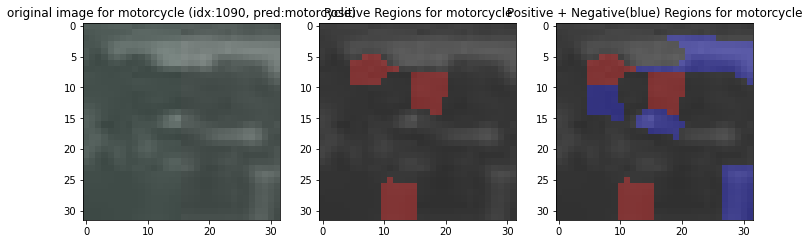

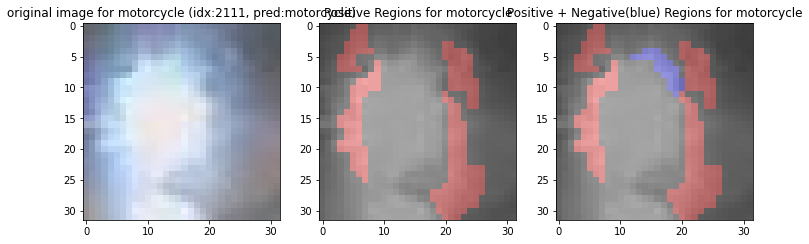

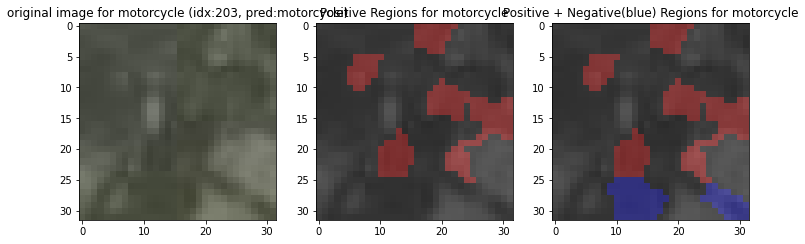

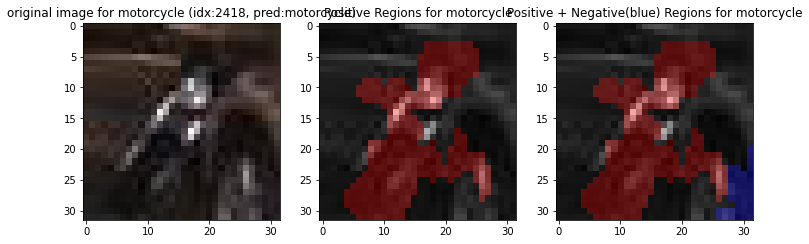

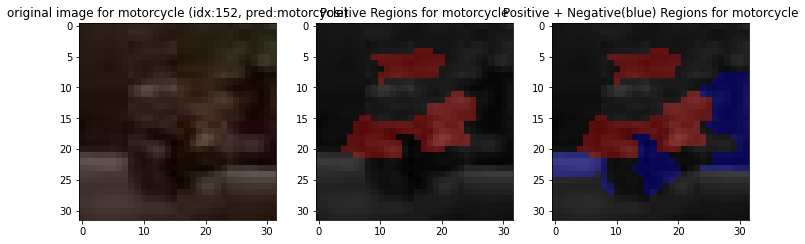

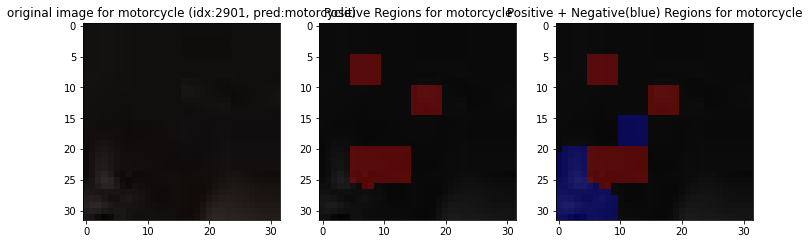

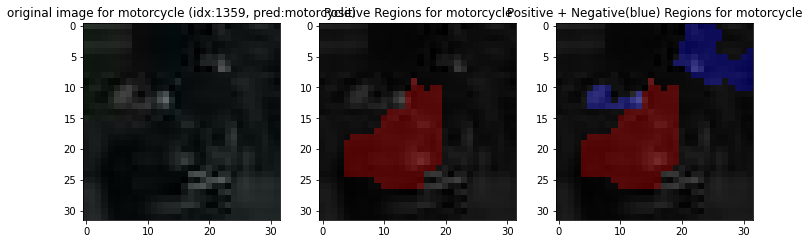

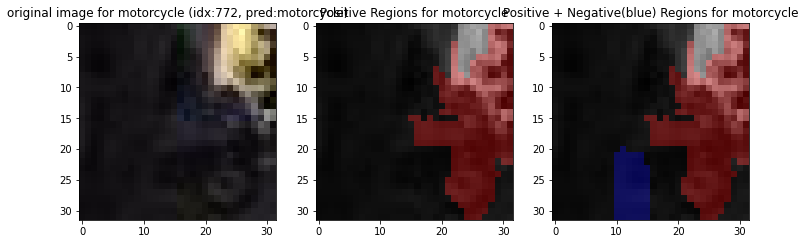

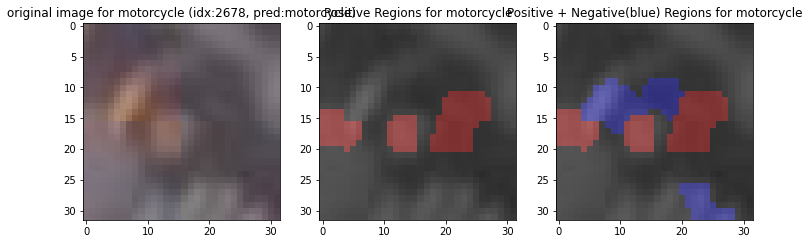

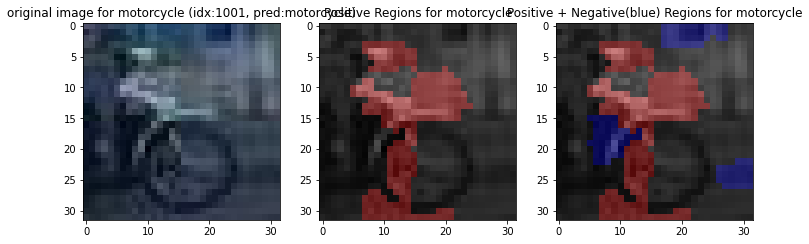

In [40]:
for class_idx,class_name in enumerate(class_names[:4]):
    np.random.seed(42)
    index_arange=np.arange(len(full_ex_image_file_list[class_idx]))
    np.random.shuffle(index_arange)
    i=0
    ex_images=[]
    part_of_index=index_arange[size*(pick_point):size*(pick_point+1)]

    for idx in part_of_index:
        ex_image=plt.imread(os.path.join(test_dir, class_name, full_ex_image_file_list[class_idx][idx]))
        ex_images.append(ex_image)
    print('range(pick:{}) :'.format(pick_point), f'{size*(pick_point)} ~ {size*(pick_point+1)}')

    ex_images_scaled=np.array(ex_images)
    ex_images_scaled=scaling_x(ex_images_scaled)

    prediction=model.predict(ex_images_scaled)
    top1_class=prediction.argmax(1)
    top1_prediction=[]
    for i, class_idx in enumerate(top1_class):
        top1_prediction.append(np.round(prediction[i][class_idx], 4))

    for idx, ex_image_scaled in enumerate(ex_images_scaled):
        exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                      classifier_fn=model.predict,# 9class의 확률 반환 (softmax)
                                      top_labels=2, # 확률 기준 1-5위 분석
                                      num_samples=1000,# 샘플링 공간
                                      segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘
         # 캔버스
        fig, (ax0, ax1, ax2)=plt.subplots(1,3,figsize=(12, 4))
        ax=[ax0, ax1,ax2]
        for i in ax:
            i.grid(False)
        # 예측에 가장 도움되는 세그먼트만 출력

        temp, mask=exp.get_image_and_mask(top1_class[idx],
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=8, # 분할 영역의 크기
                                         hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
        ax0.imshow(ex_images[idx])
        ax0.set_title('original image for {} (idx:{}, pred:{})'.format(class_name, part_of_index[idx], class_names[top1_class[idx]]))

        # label2rgb : 형광색 마스킹
        ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
        ax1.set_title('Positive Regions for {}'.format(class_name))

        # 모든 세그먼트 출력
        temp, mask=exp.get_image_and_mask(top1_class[idx],
                                         positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=8, # 분할 영역의 크기
                                         hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
        # 부정형 제거
        mask*=-1# 색 반전

        mask2=mask.copy()
        mask2[mask2==1]=0

        ax1.imshow(label2rgb(mask2, ex_images[idx], bg_label=0))
        ax2.imshow(label2rgb(mask, ex_images[idx], bg_label=0), interpolation='nearest')
    #     ax2.set_title('Show output image only')
    #     ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
        ax2.set_title('Positive + Negative(blue) Regions for {}'.format(class_name))

In [19]:
best_index=[727, 1600, 152 , 1547, 2111,1090 ,1001 , 727, 772]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

range(pick:1) : 30 ~ 60


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

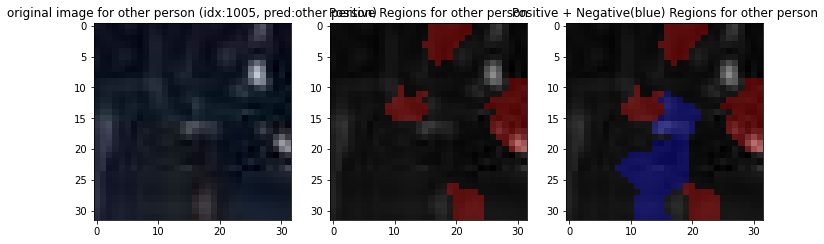

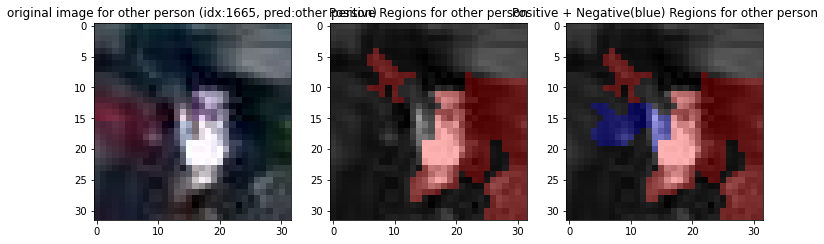

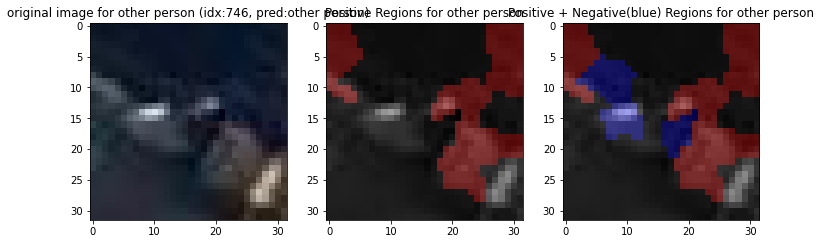

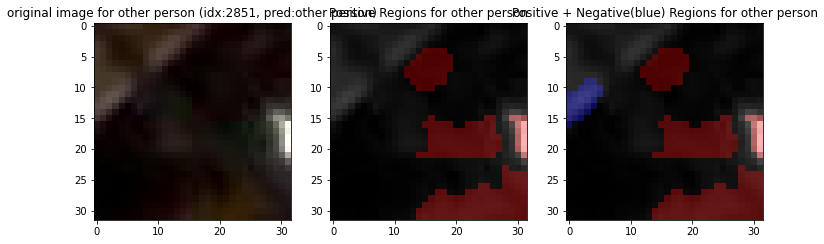

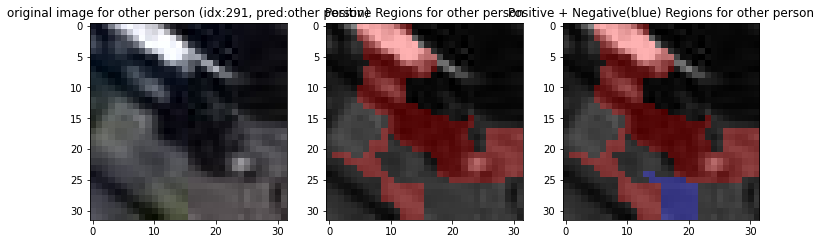

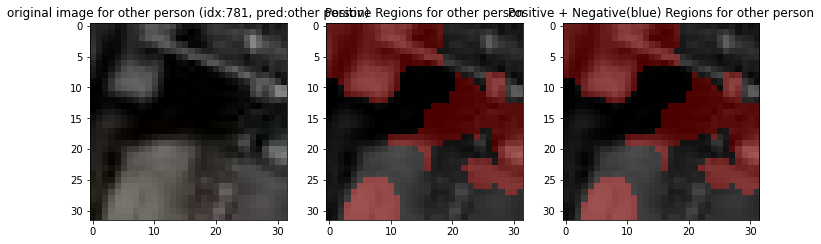

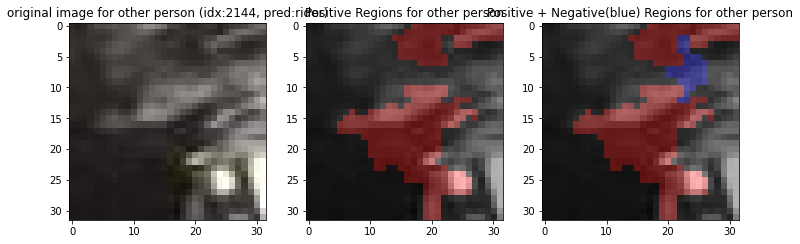

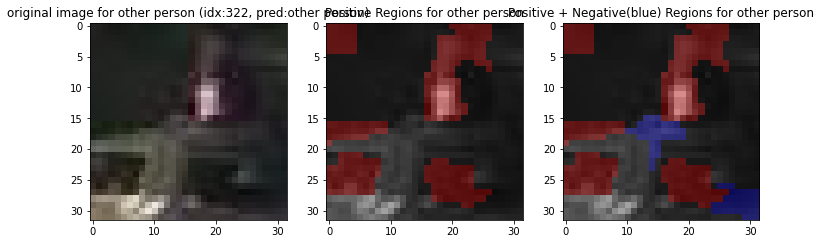

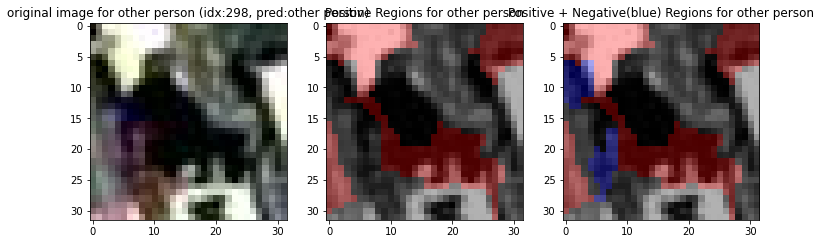

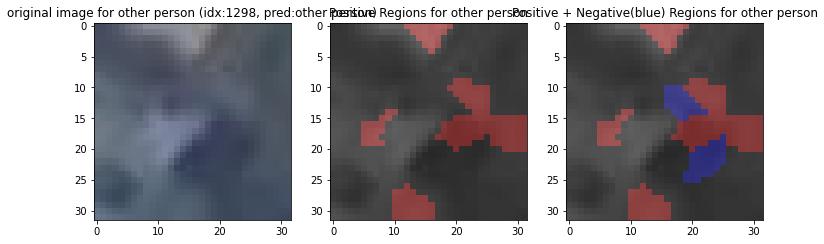

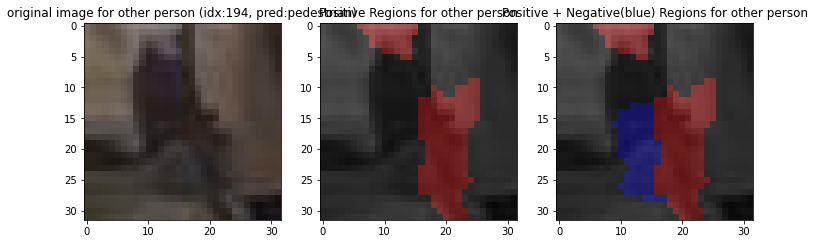

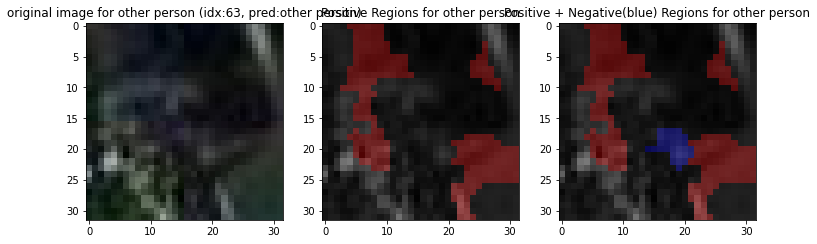

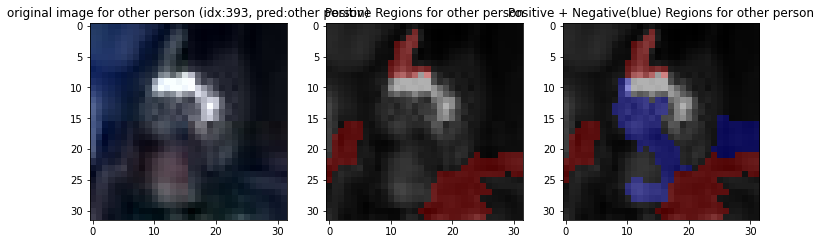

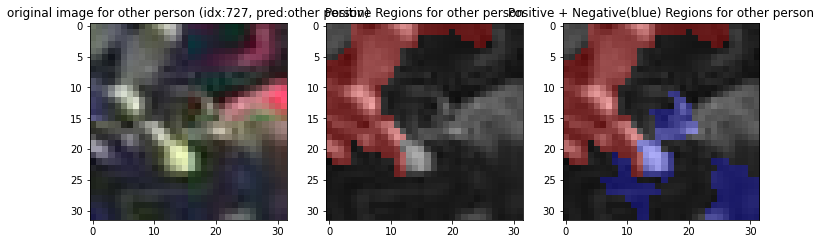

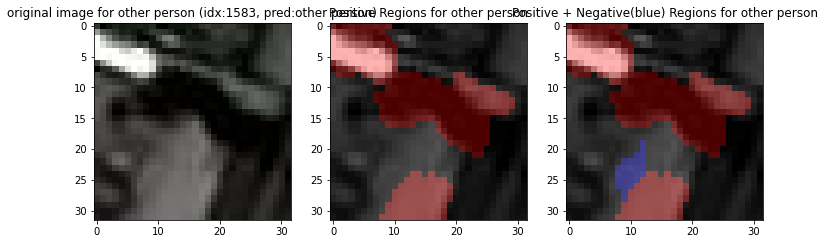

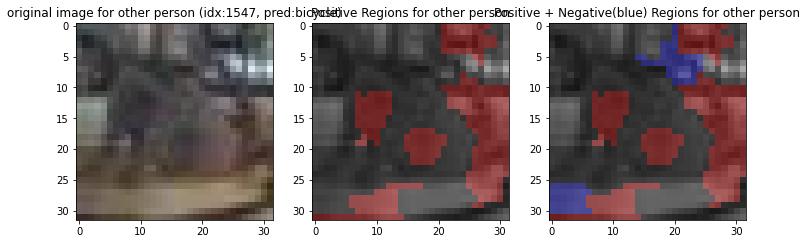

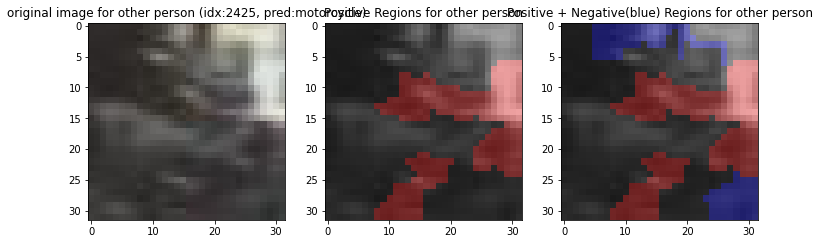

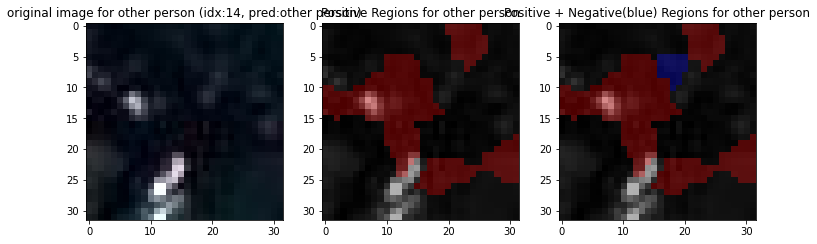

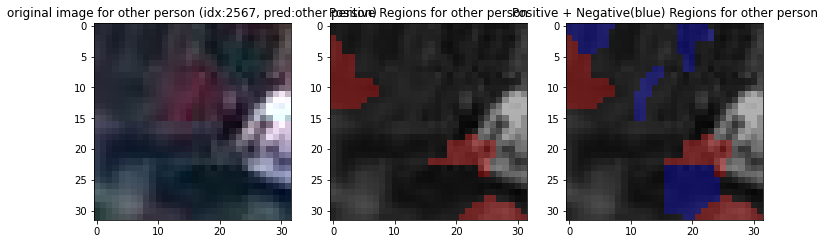

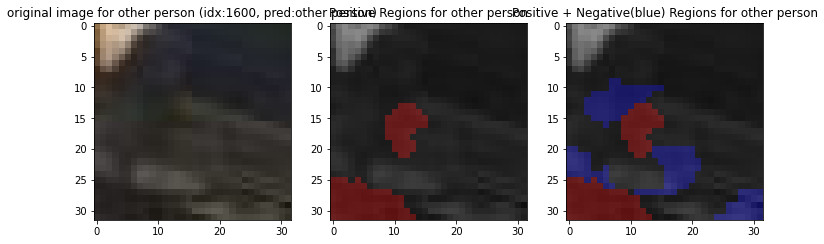

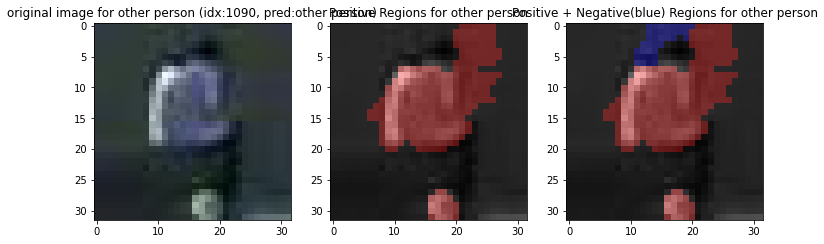

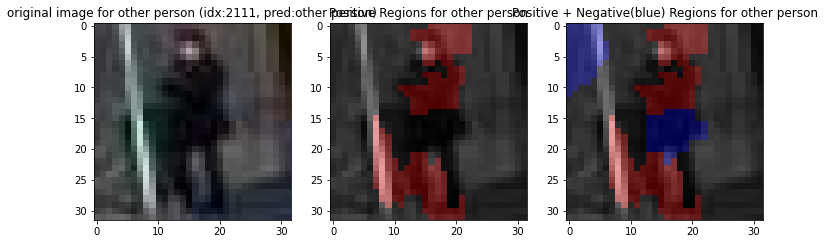

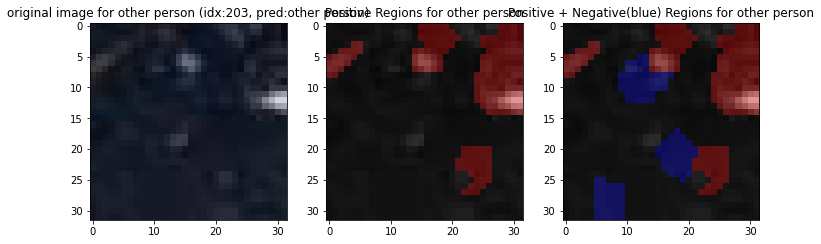

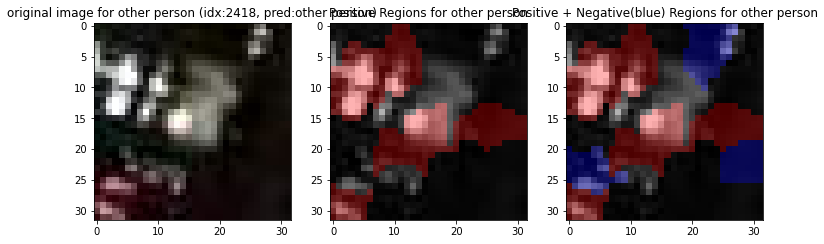

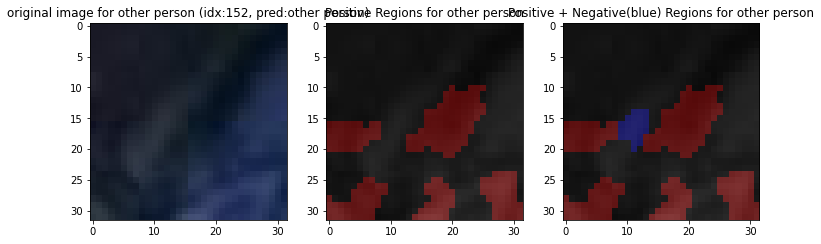

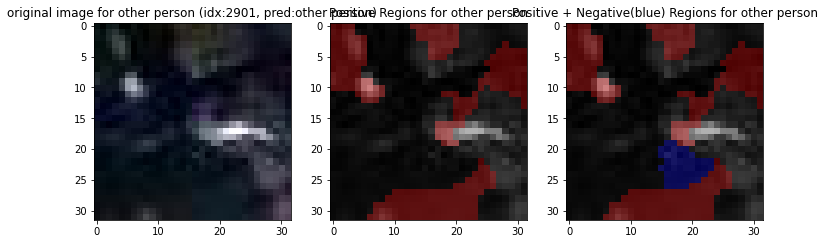

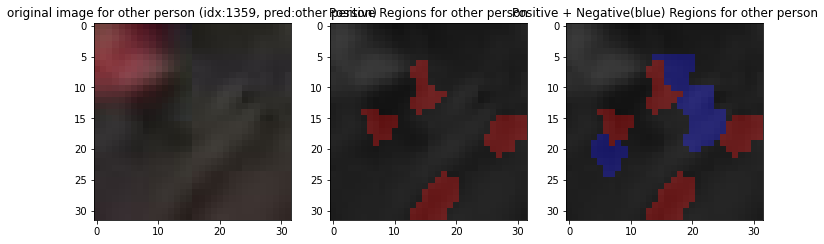

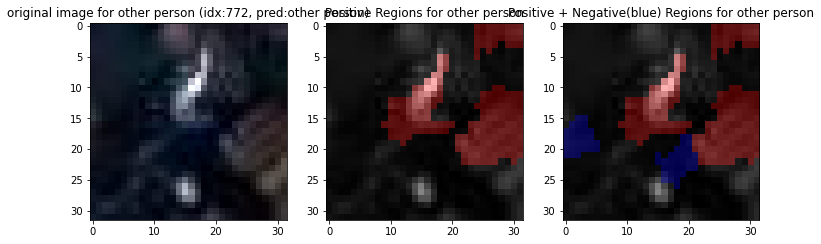

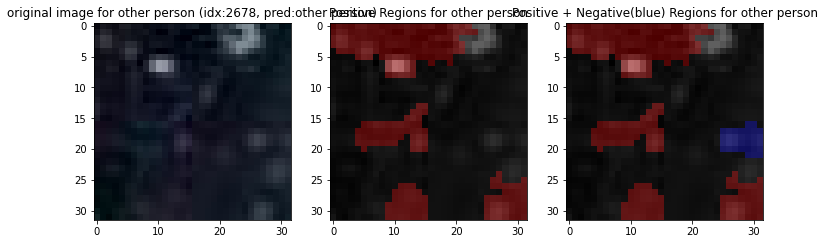

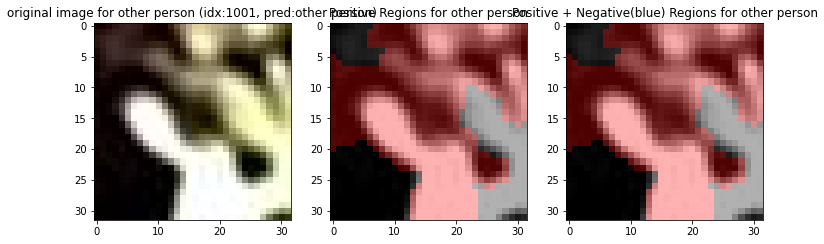

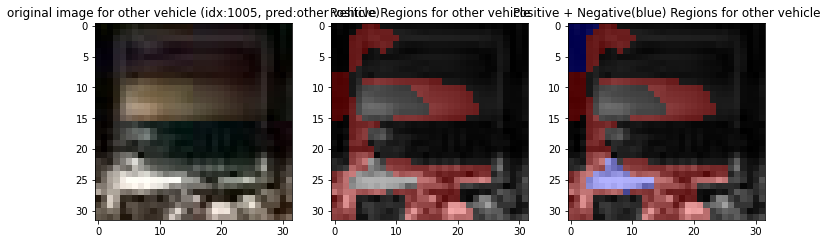

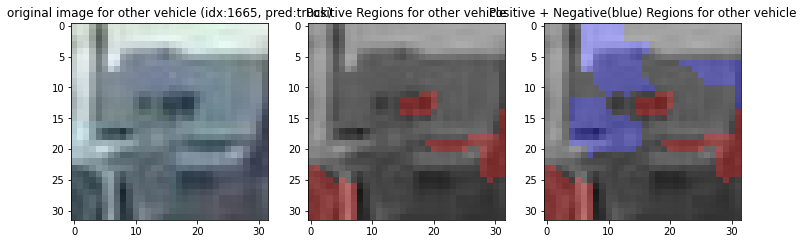

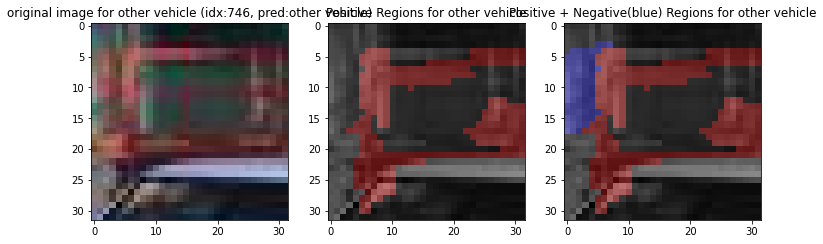

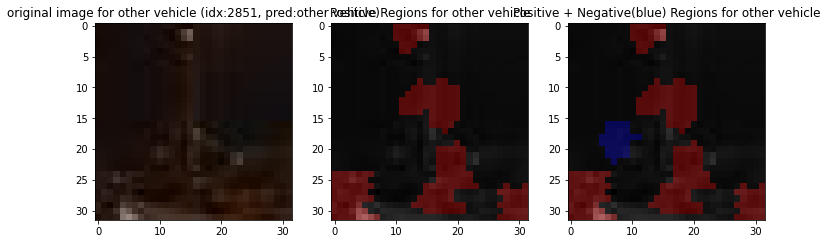

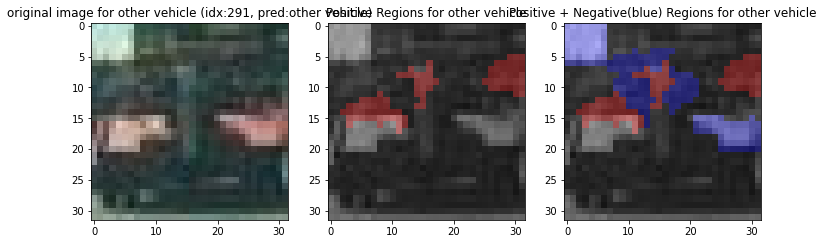

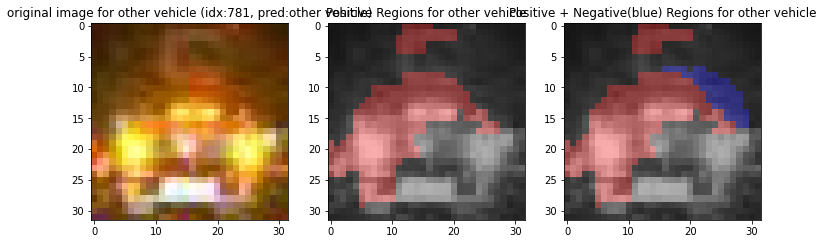

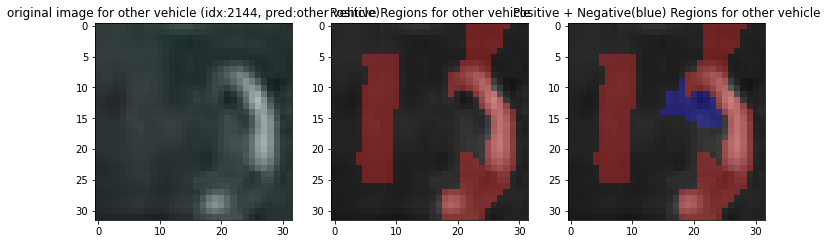

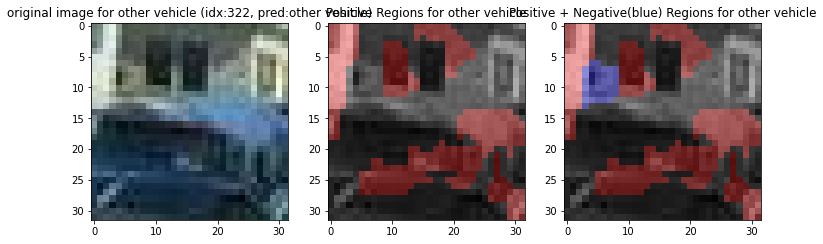

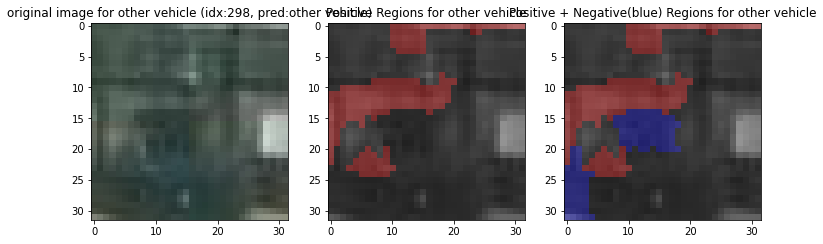

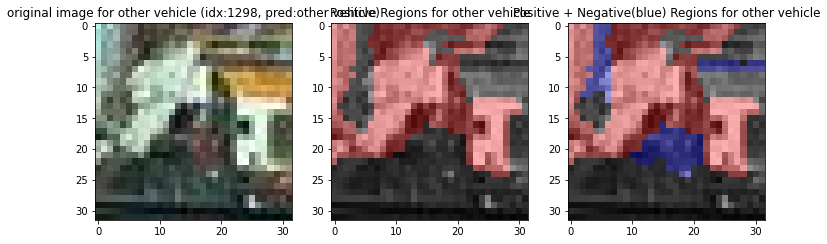

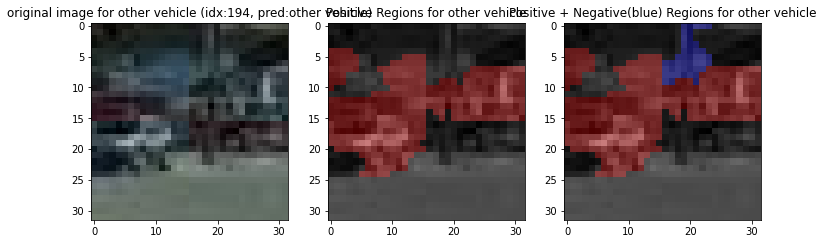

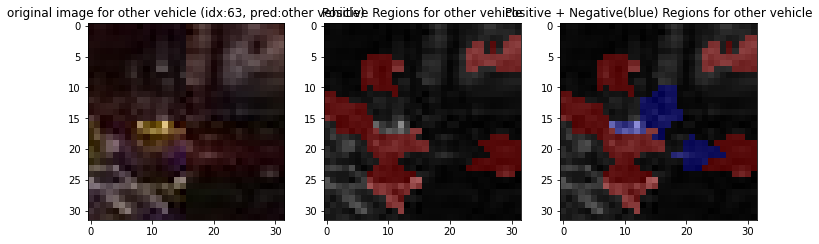

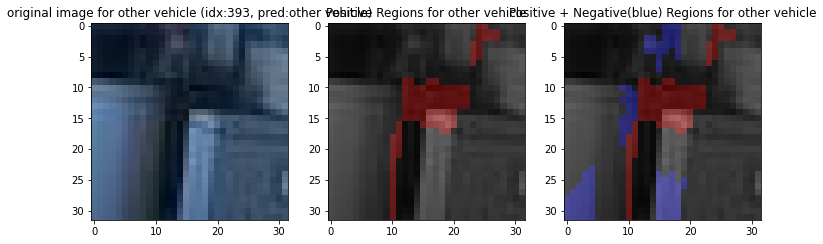

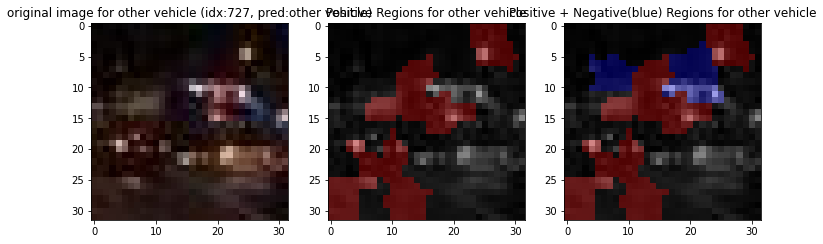

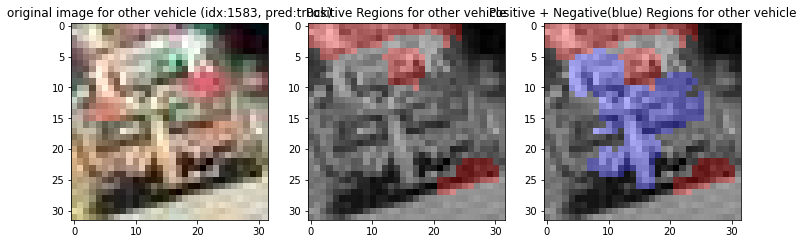

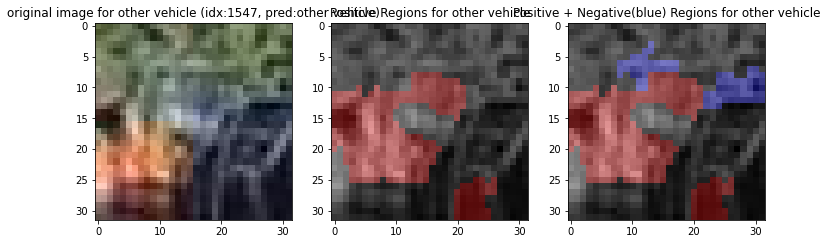

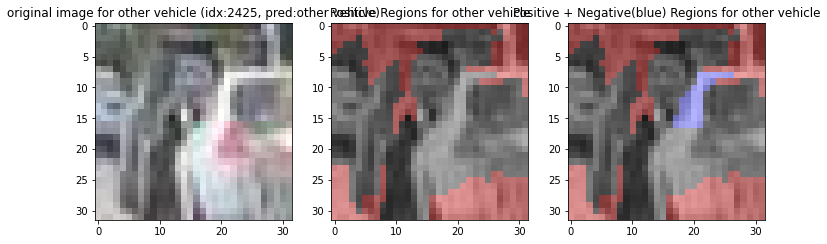

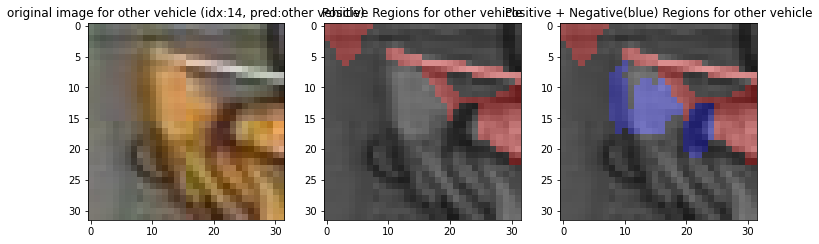

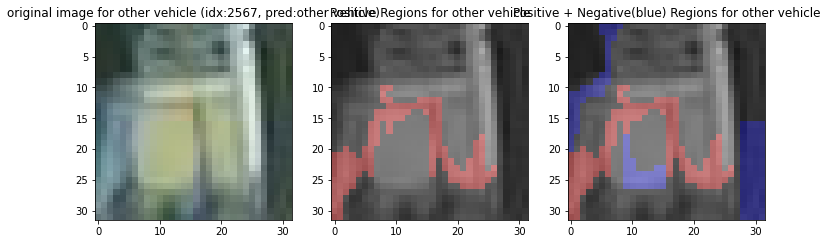

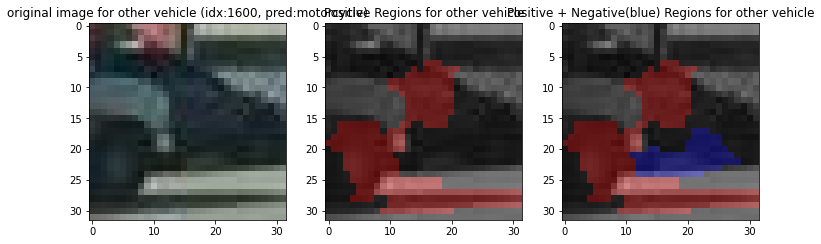

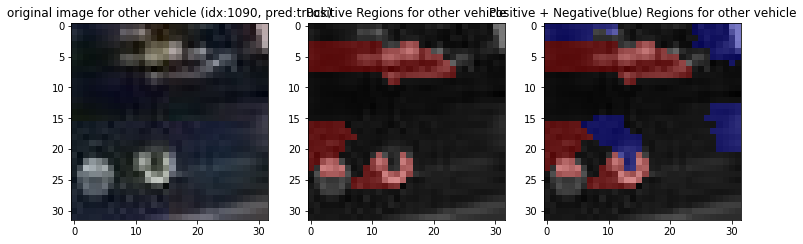

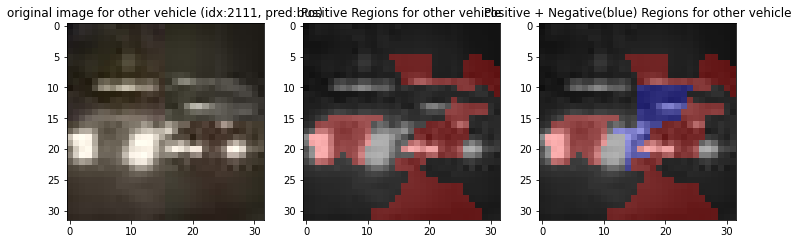

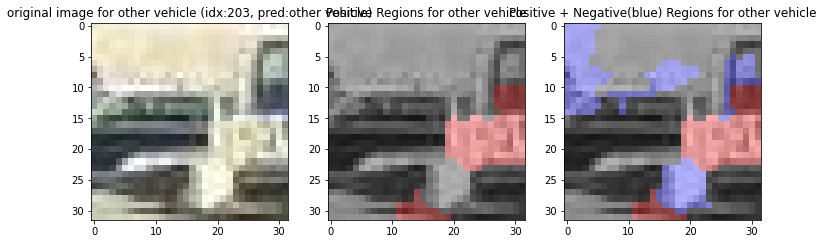

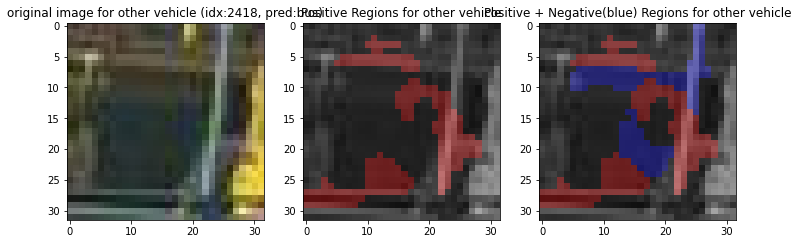

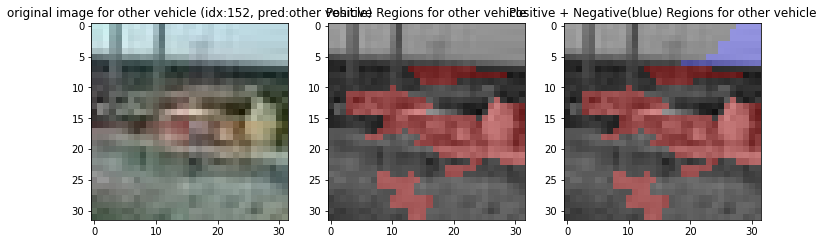

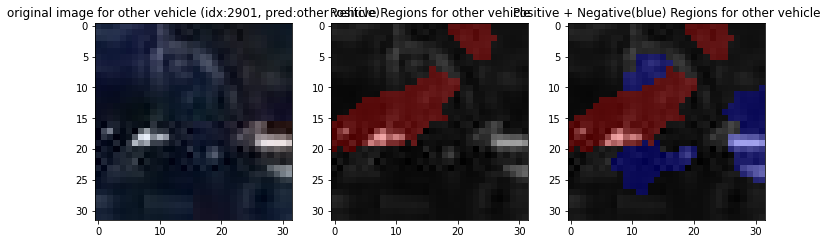

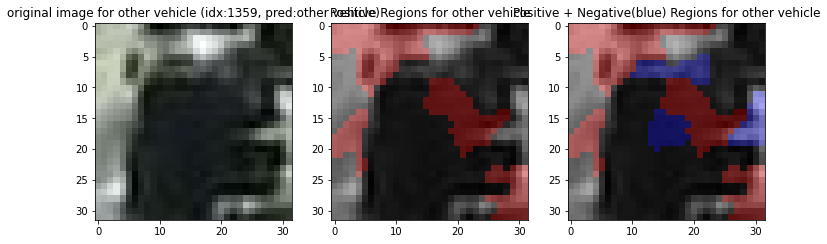

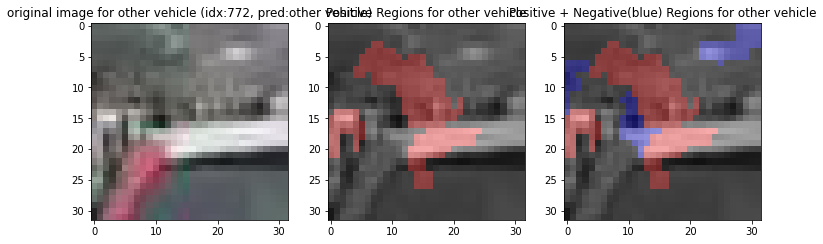

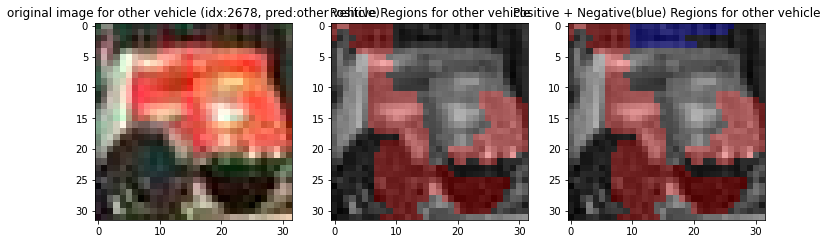

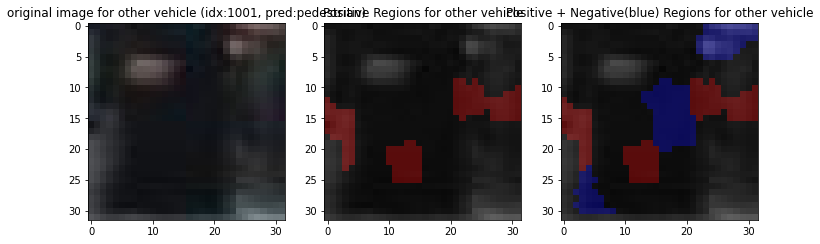

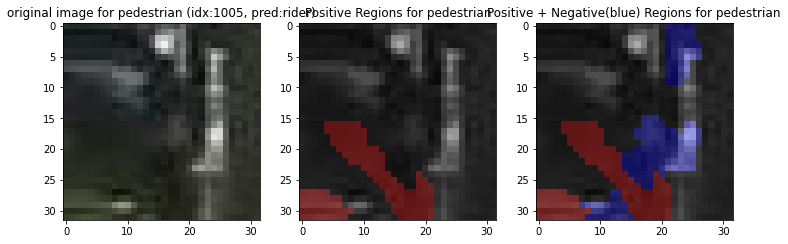

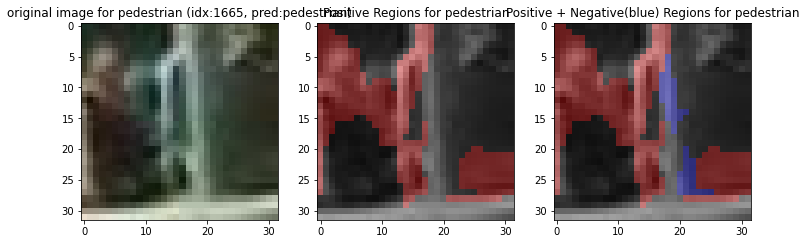

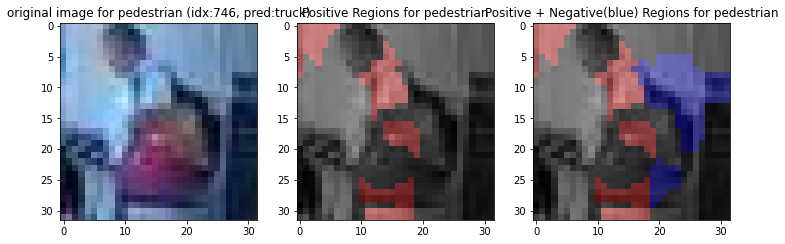

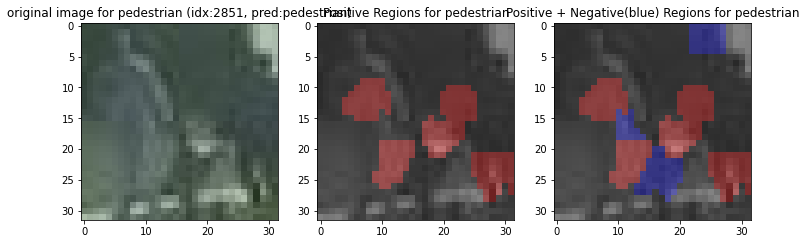

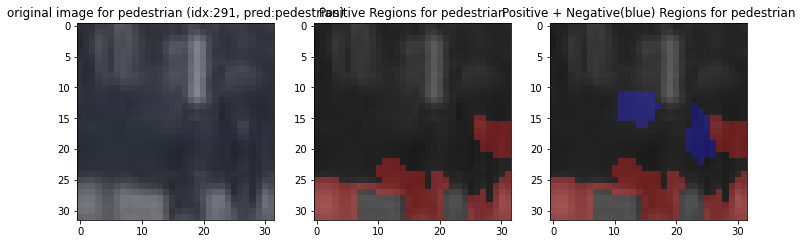

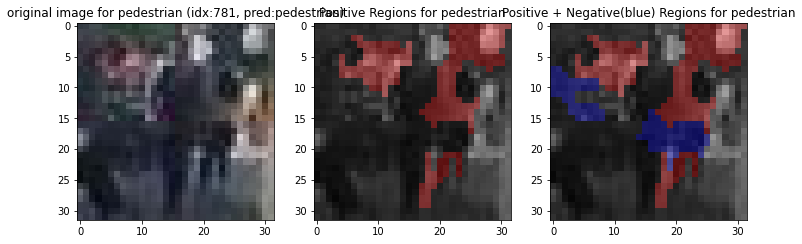

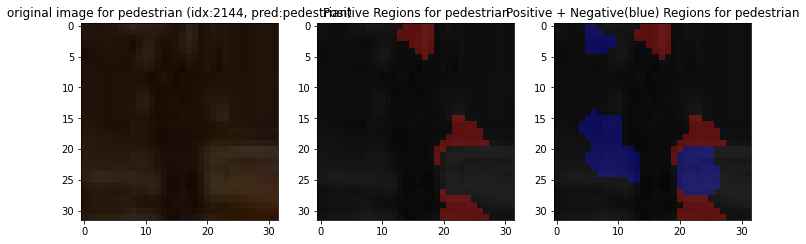

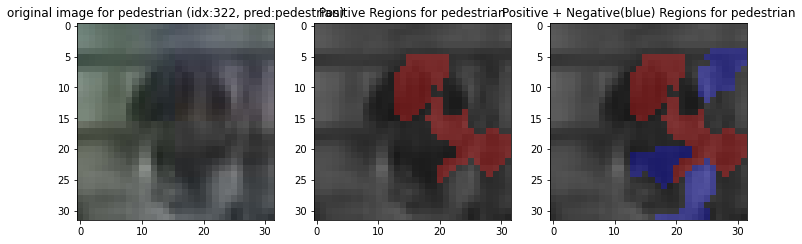

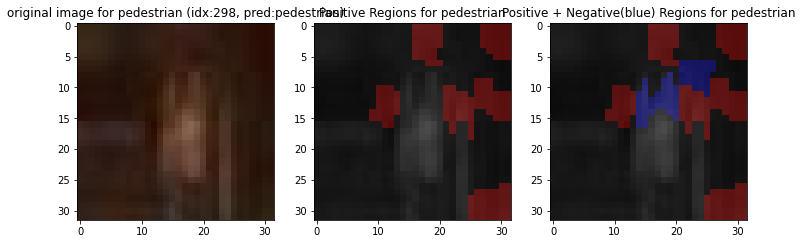

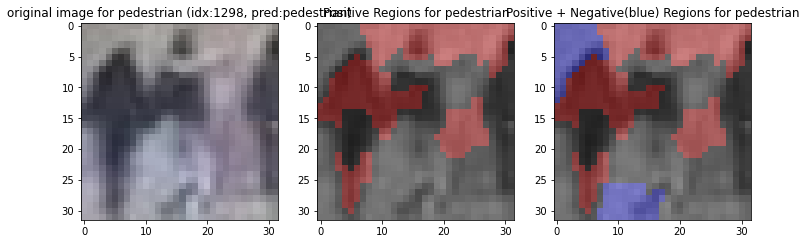

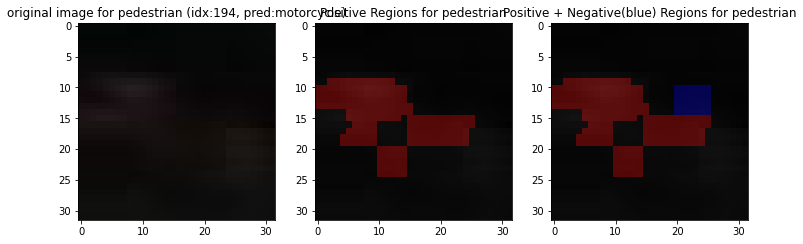

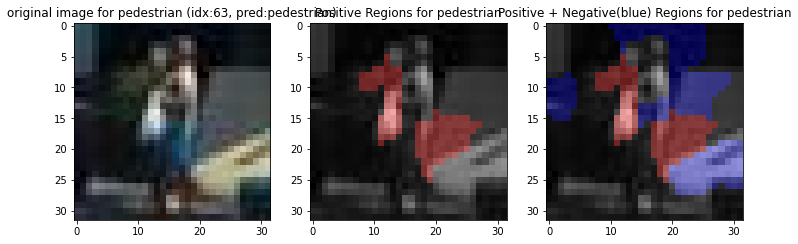

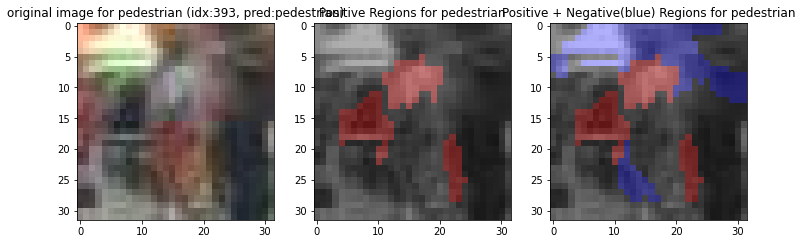

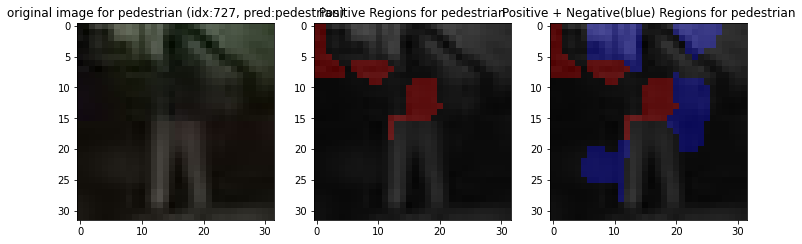

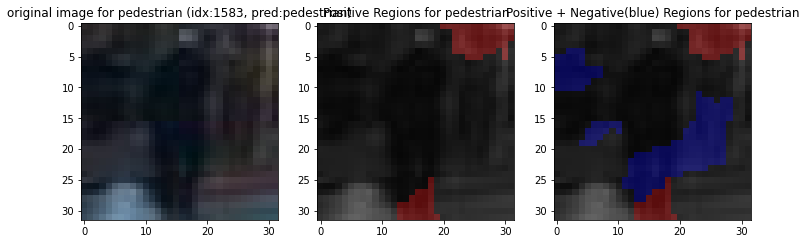

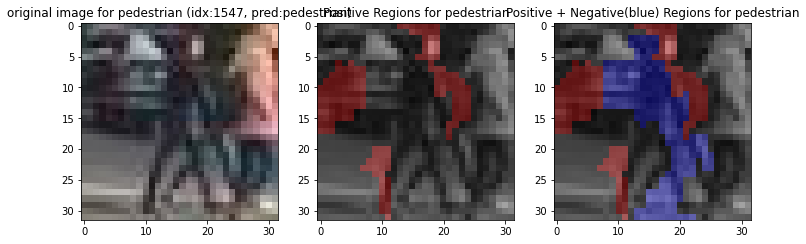

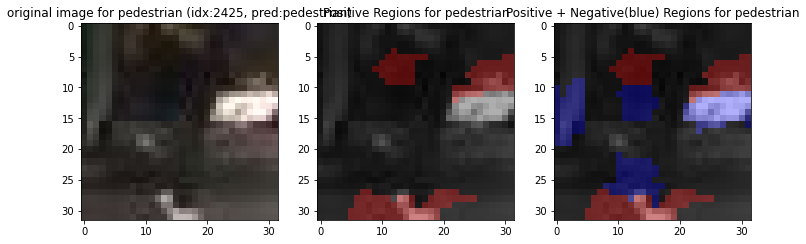

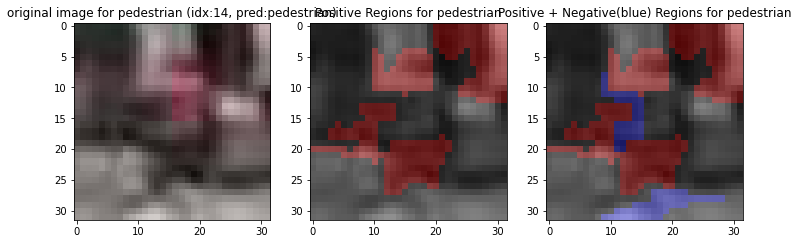

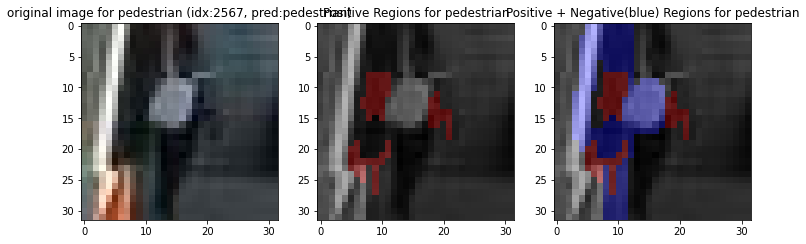

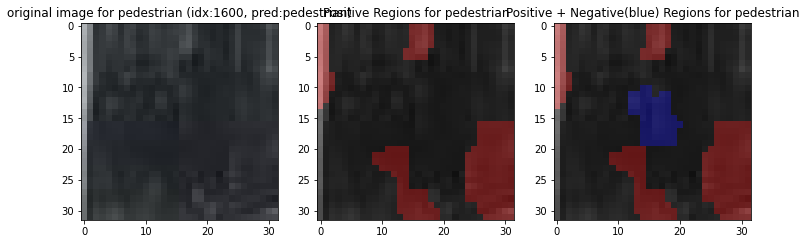

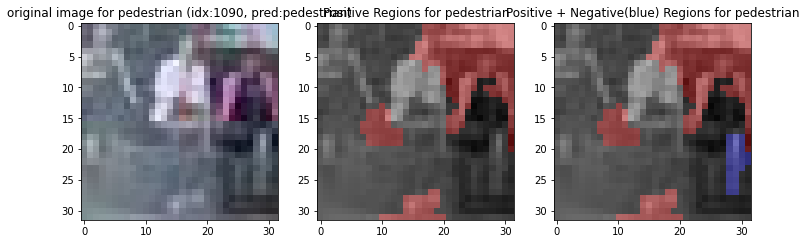

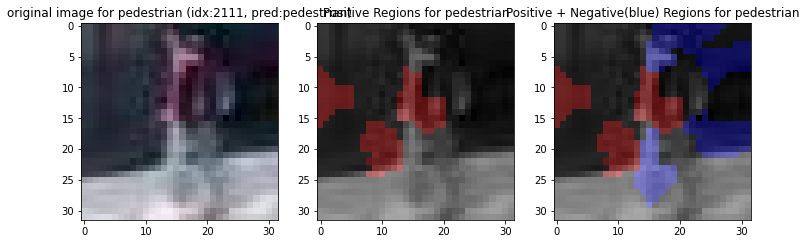

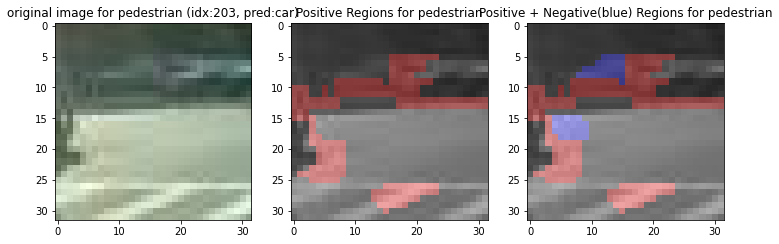

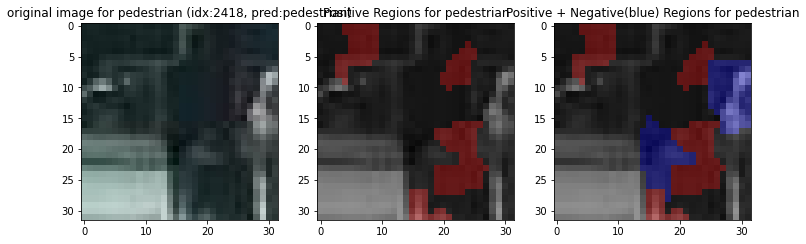

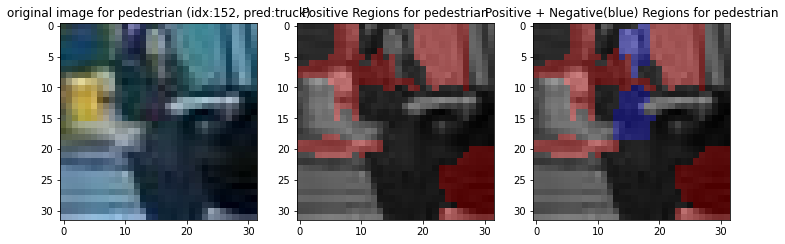

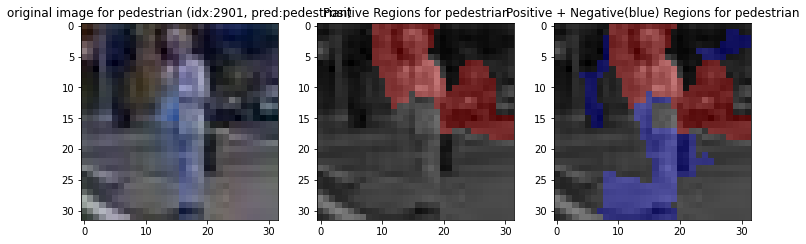

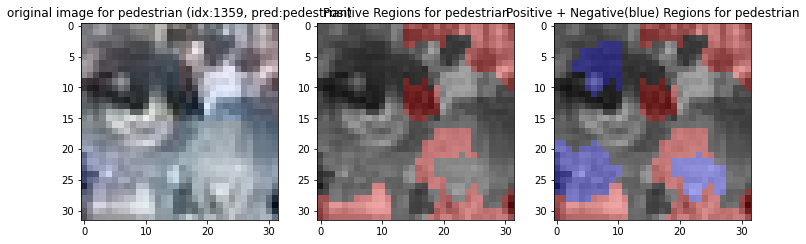

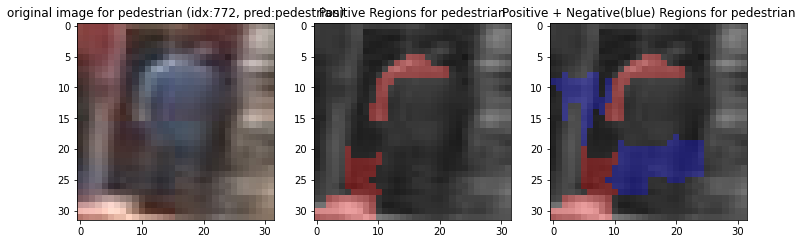

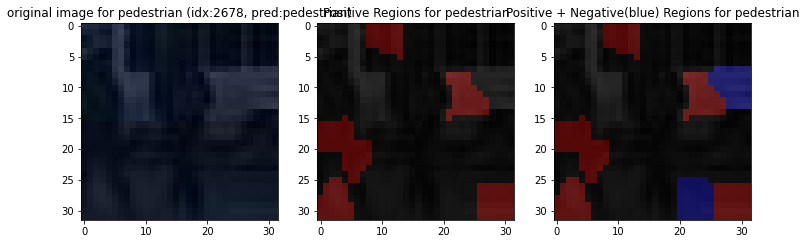

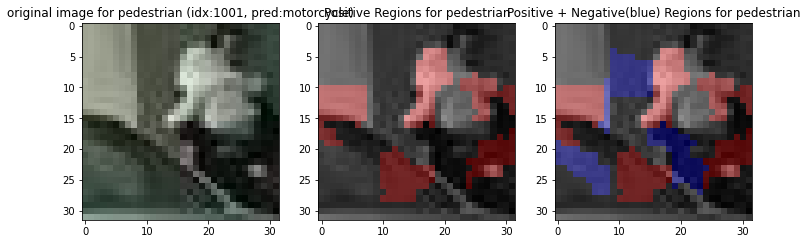

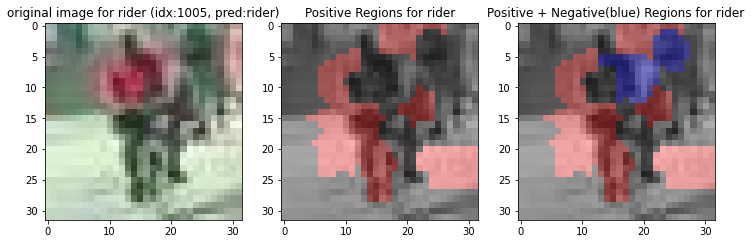

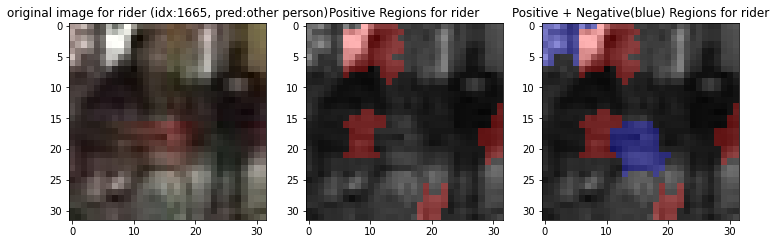

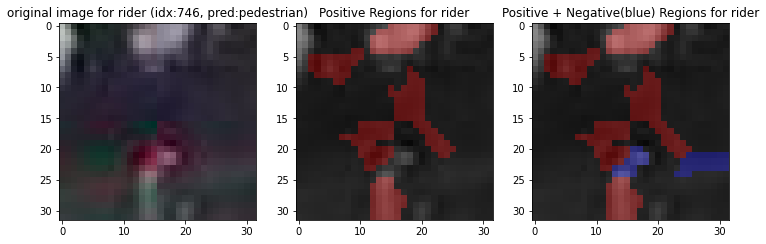

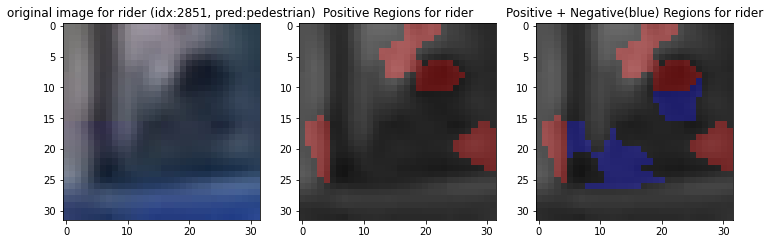

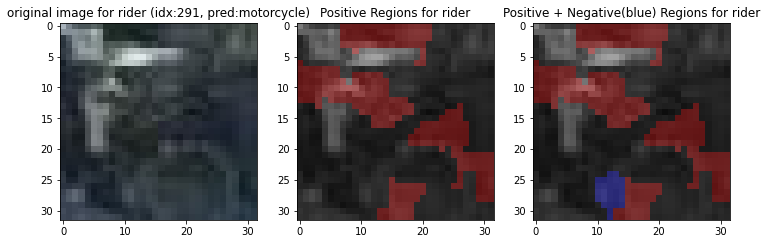

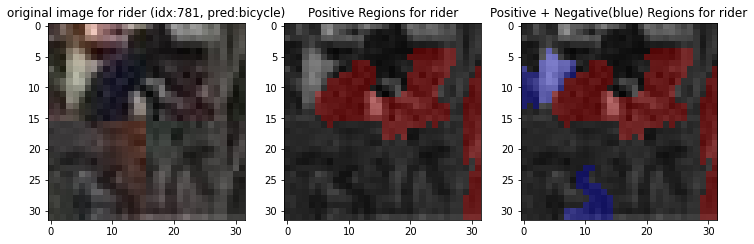

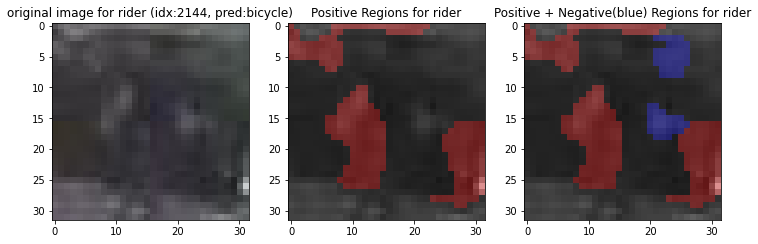

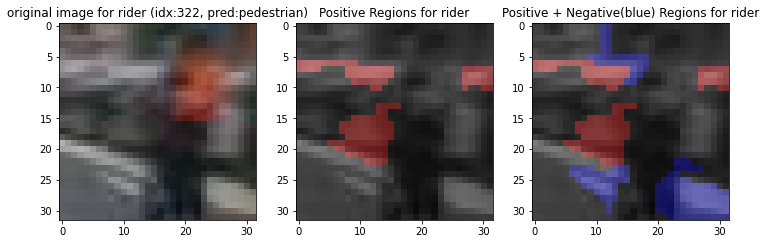

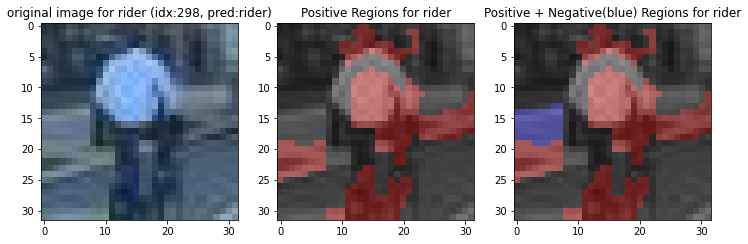

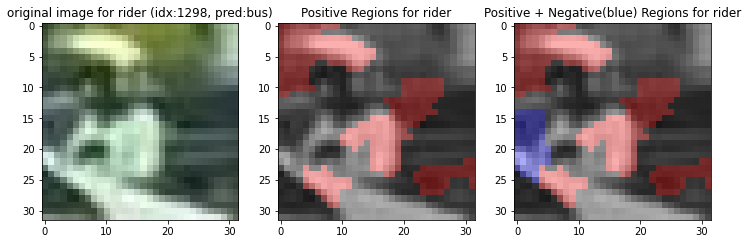

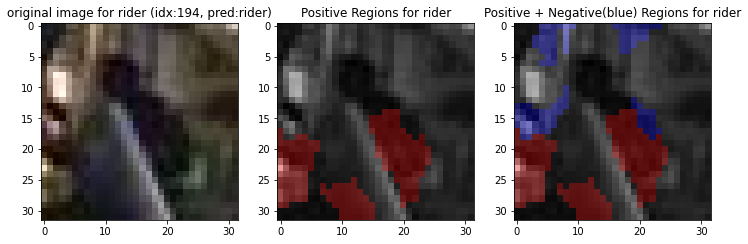

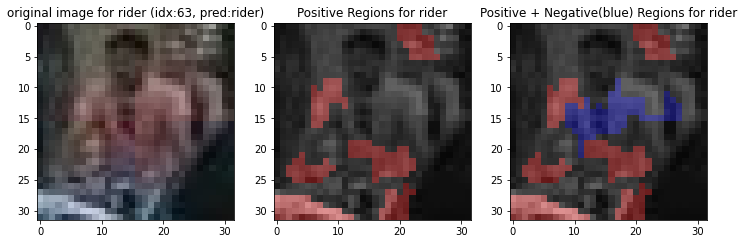

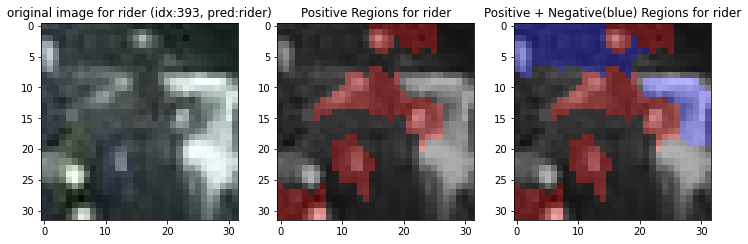

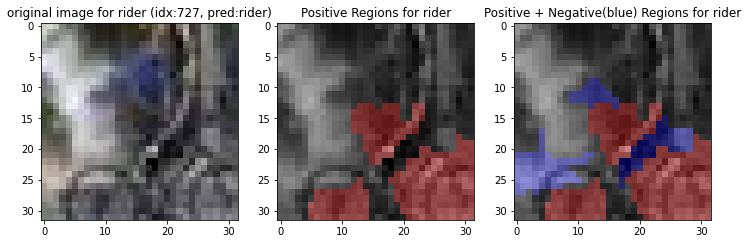

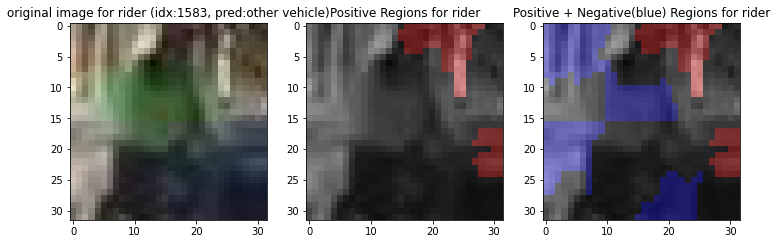

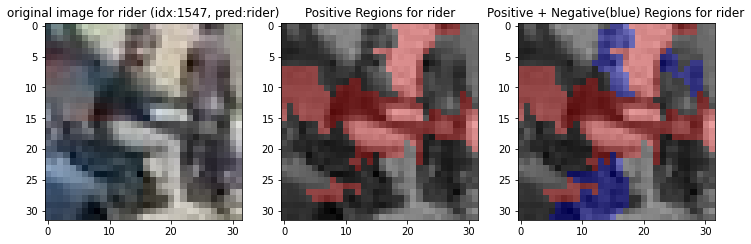

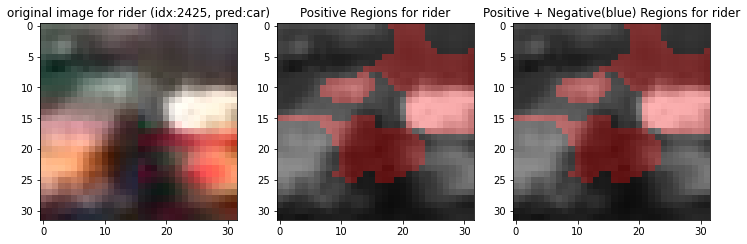

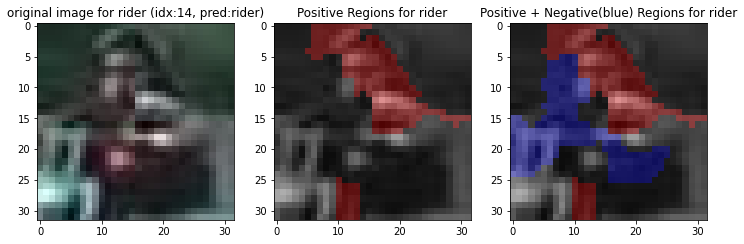

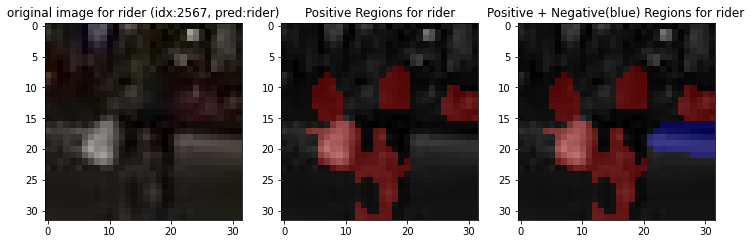

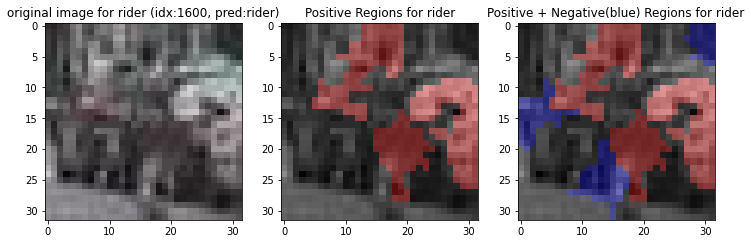

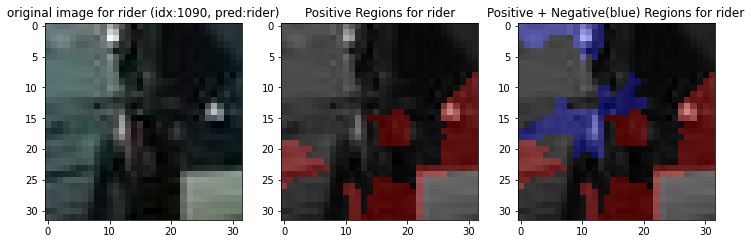

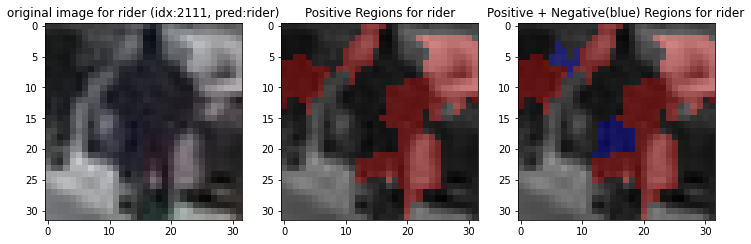

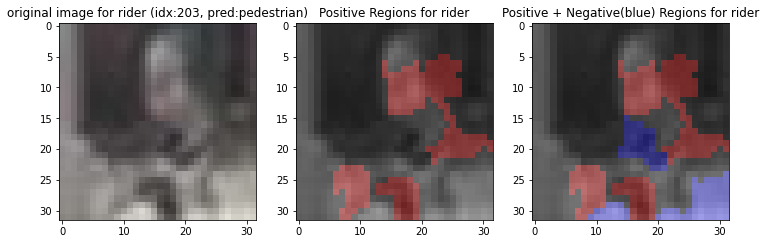

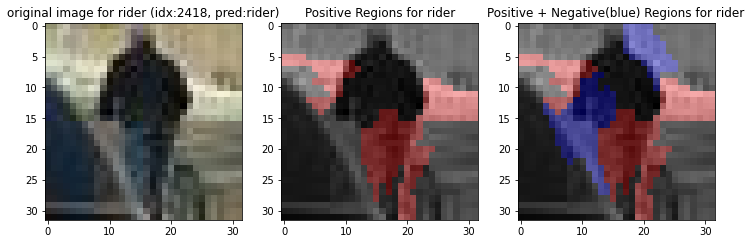

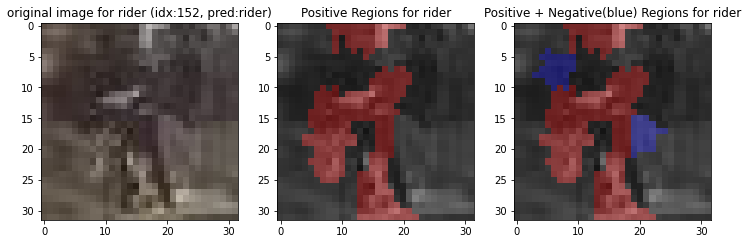

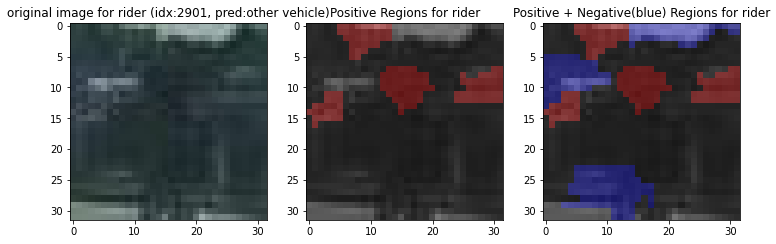

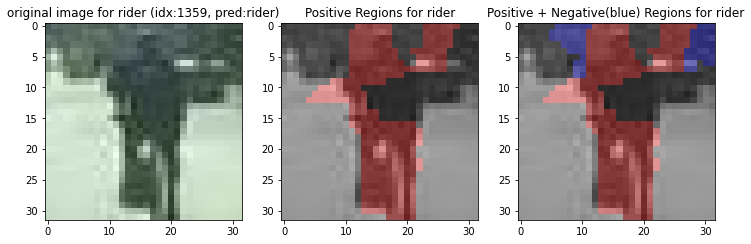

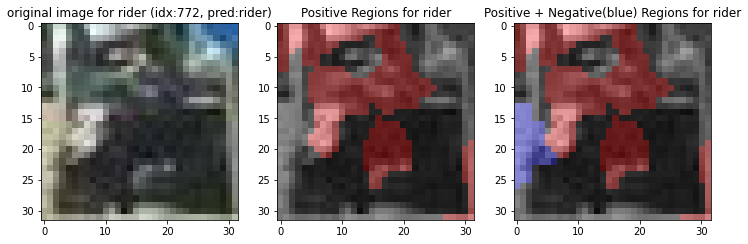

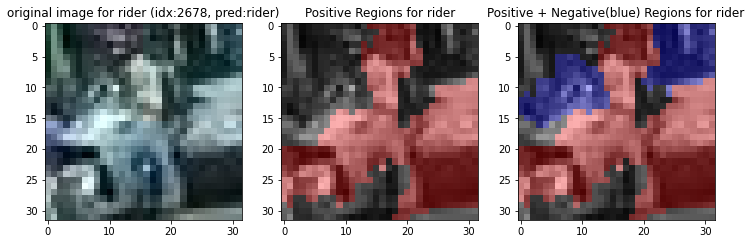

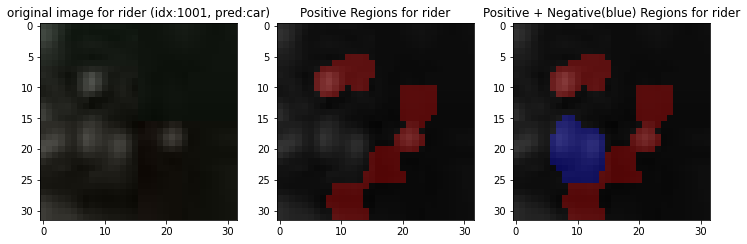

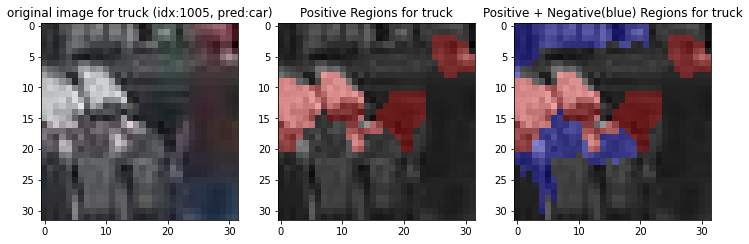

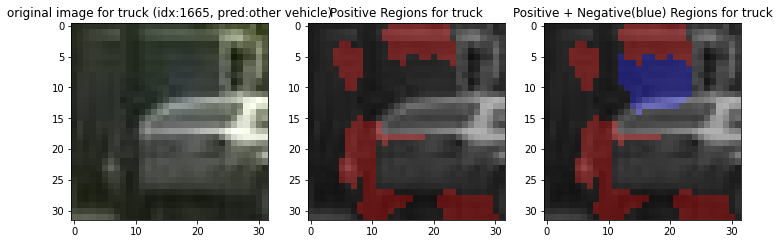

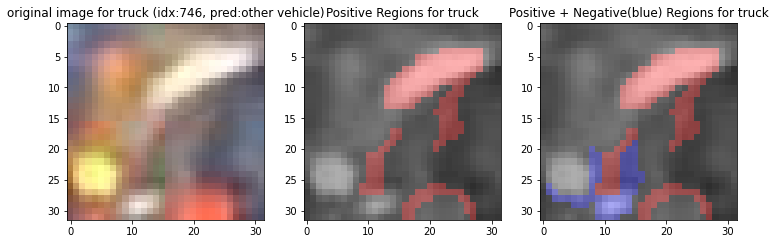

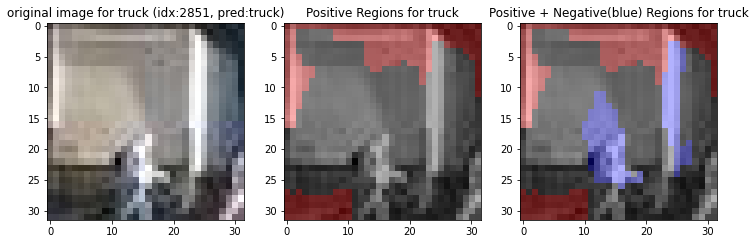

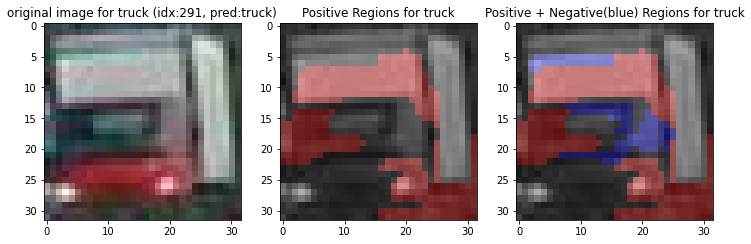

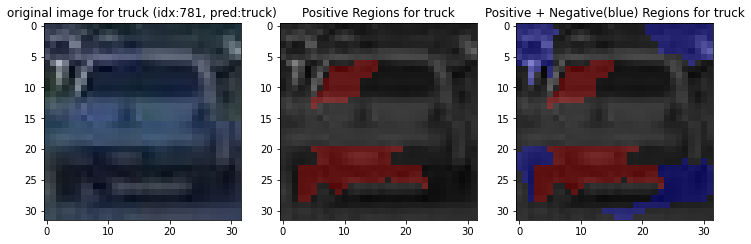

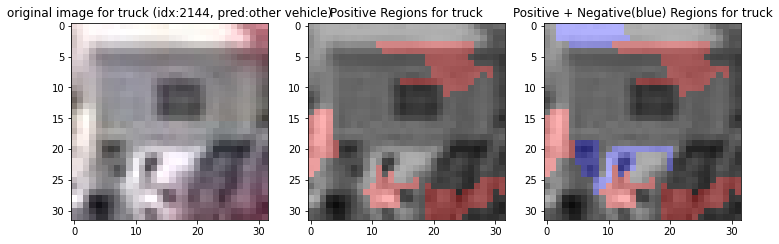

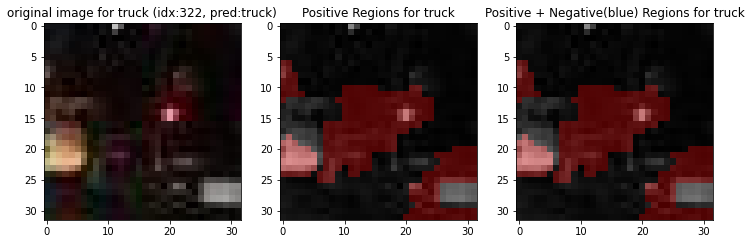

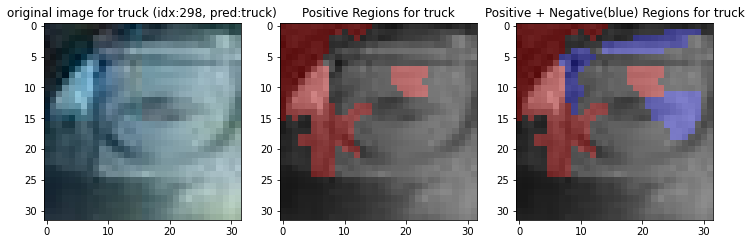

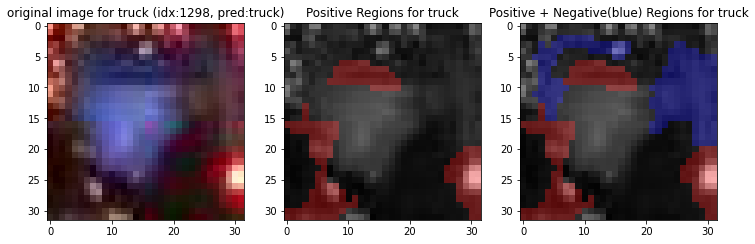

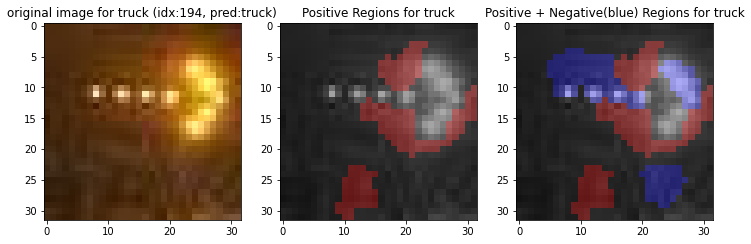

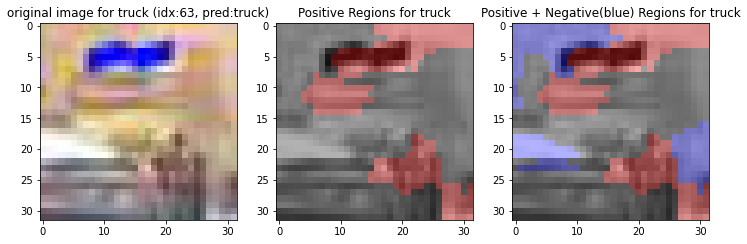

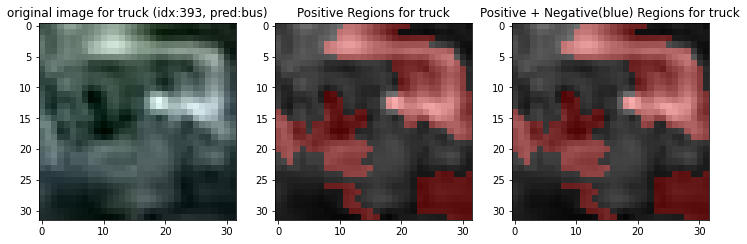

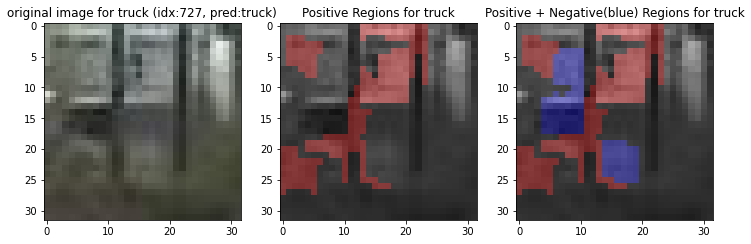

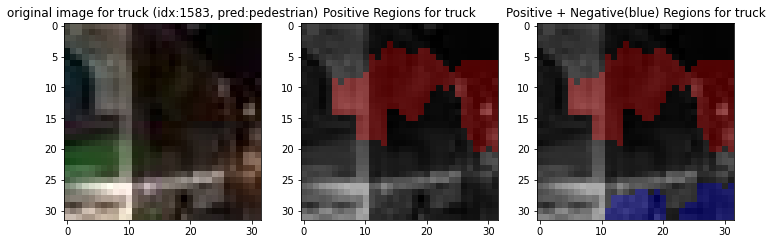

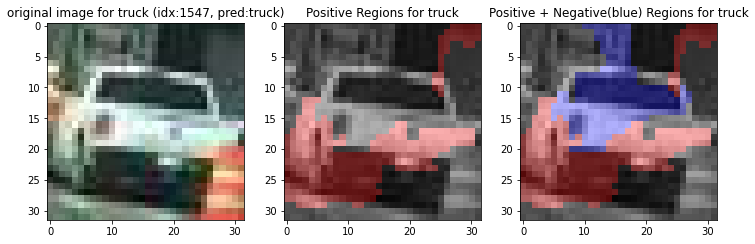

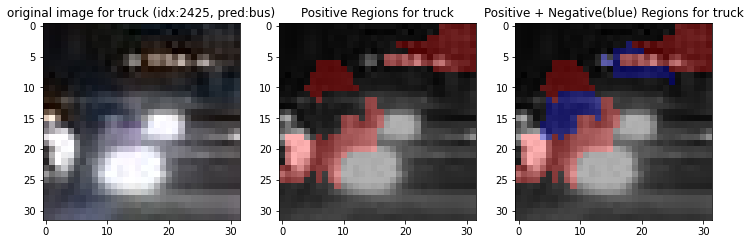

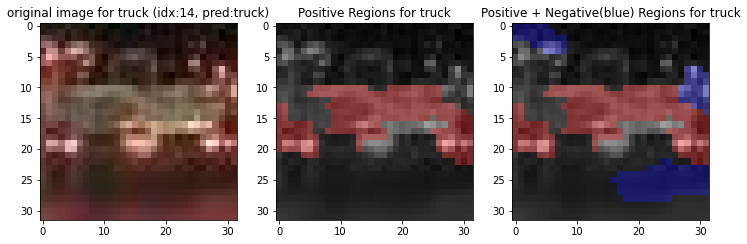

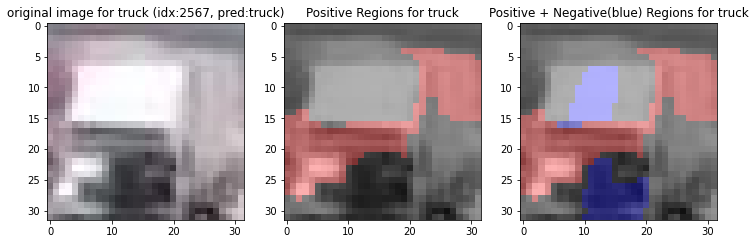

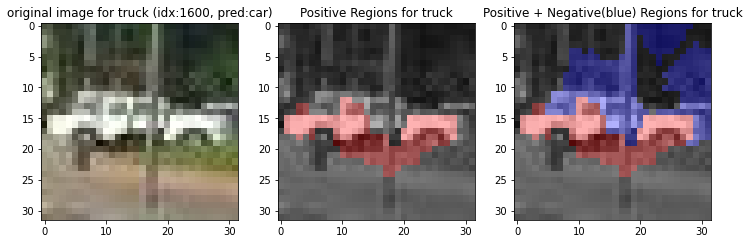

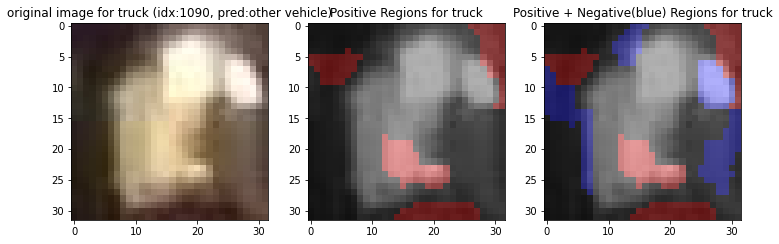

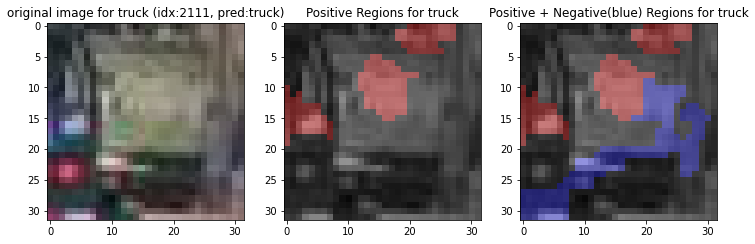

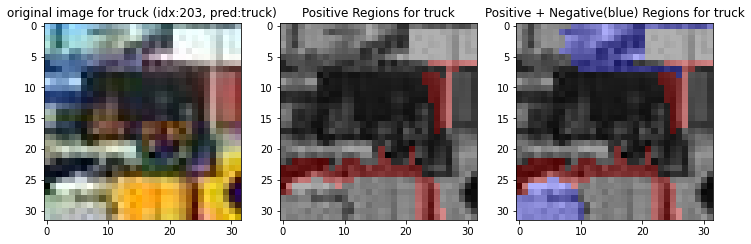

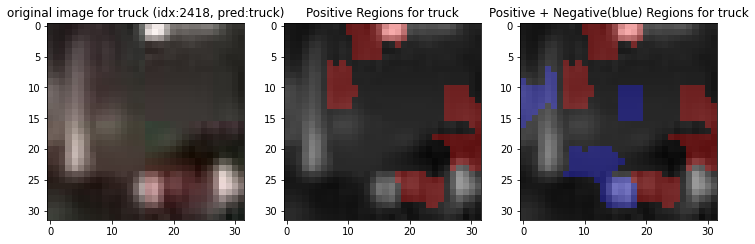

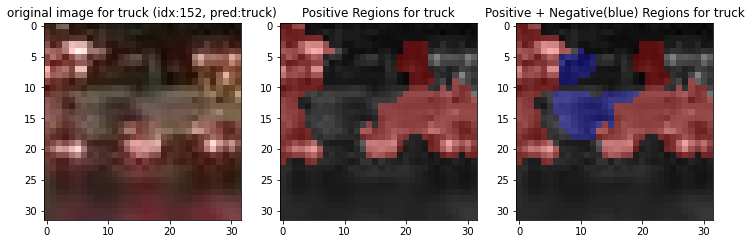

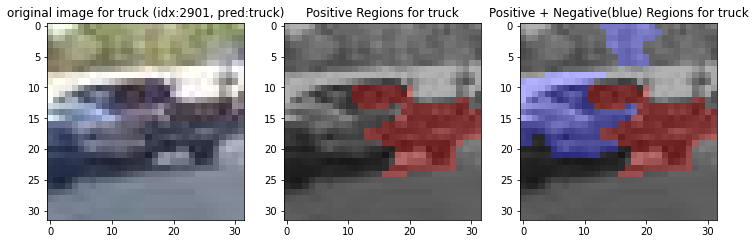

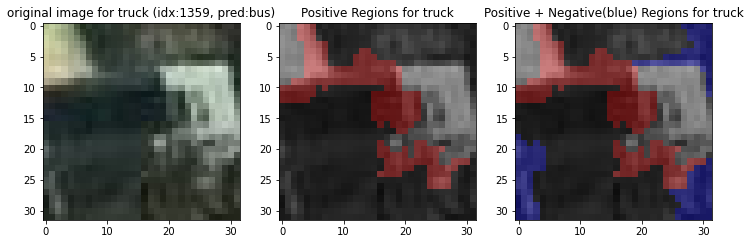

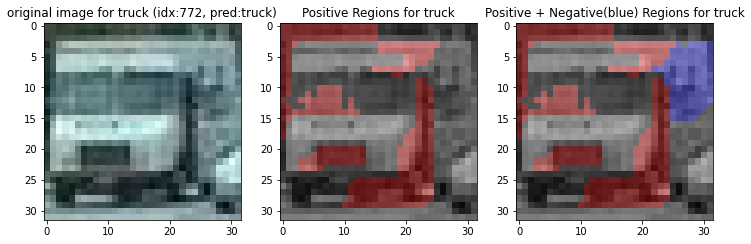

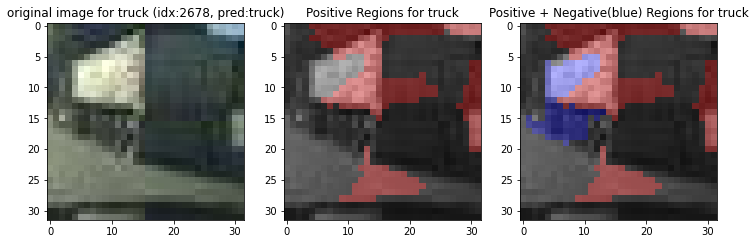

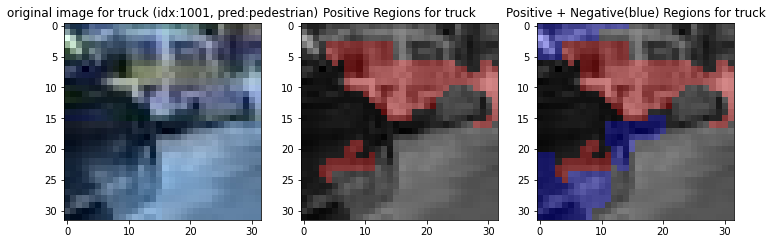

In [45]:
for class_idx,class_name in enumerate(class_names[4:]):
    
    class_idx+=4
    
    np.random.seed(42)
    index_arange=np.arange(len(full_ex_image_file_list[class_idx]))
    np.random.shuffle(index_arange)
    i=0
    ex_images=[]
    part_of_index=index_arange[size*(pick_point):size*(pick_point+1)]

    for idx in part_of_index:
        ex_image=plt.imread(os.path.join(test_dir, class_name, full_ex_image_file_list[class_idx][idx]))
        ex_images.append(ex_image)
    print('range(pick:{}) :'.format(pick_point), f'{size*(pick_point)} ~ {size*(pick_point+1)}')

    ex_images_scaled=np.array(ex_images)
    ex_images_scaled=scaling_x(ex_images_scaled)

    prediction=model.predict(ex_images_scaled)
    top1_class=prediction.argmax(1)
    top1_prediction=[]
    for i, class_idx in enumerate(top1_class):
        top1_prediction.append(np.round(prediction[i][class_idx], 4))


    for idx, ex_image_scaled in enumerate(ex_images_scaled):
        exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                      classifier_fn=model.predict,# 9class의 확률 반환 (softmax)
                                      top_labels=2, # 확률 기준 1-5위 분석
                                      num_samples=1000,# 샘플링 공간
                                      segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘
         # 캔버스
        fig, (ax0, ax1, ax2)=plt.subplots(1,3,figsize=(12, 4))
        ax=[ax0, ax1,ax2]
        for i in ax:
            i.grid(False)
        # 예측에 가장 도움되는 세그먼트만 출력

        temp, mask=exp.get_image_and_mask(top1_class[idx],
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=8, # 분할 영역의 크기
                                         hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
        ax0.imshow(ex_images[idx])
        ax0.set_title('original image for {} (idx:{}, pred:{})'.format(class_name, part_of_index[idx], class_names[top1_class[idx]]))

        # label2rgb : 형광색 마스킹
        ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
        ax1.set_title('Positive Regions for {}'.format(class_name))

        # 모든 세그먼트 출력
        temp, mask=exp.get_image_and_mask(top1_class[idx],
                                         positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=8, # 분할 영역의 크기
                                         hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
        # 부정형 제거
        mask*=-1# 색 반전

        mask2=mask.copy()
        mask2[mask2==1]=0

        ax1.imshow(label2rgb(mask2, ex_images[idx], bg_label=0))
        ax2.imshow(label2rgb(mask, ex_images[idx], bg_label=0), interpolation='nearest')
    #     ax2.set_title('Show output image only')
    #     ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
        ax2.set_title('Positive + Negative(blue) Regions for {}'.format(class_name))

In [ ]:
[ , , , , 2111,1090 ,1001 , 727, 772]

# BEST

In [ ]:
best_index=[727, 1600, 152 , 1547, 2111,1090 ,1001 , 727, 772]

In [25]:
# model_regressor를 수정해 설명 모델을 바꿀 수 있고
# segmentation_fn 파라미터를 수정해 이미지분할 알고리즘을 사용할 수 있다.
# 슈퍼픽셀 : 디지털 이미지를 구성하는 점들 중 같은 정보를 가진 점의 집합을 의미한다.

from lime import lime_image # 이미지 모듈
from lime.wrappers.scikit_image import SegmentationAlgorithm # liem이 사용할 수 있게. 

explainer=lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(default), slic, felzenswalb


In [26]:
compact=5
segments=50
sigma=0.5

sample_idx=5
segmenter=SegmentationAlgorithm('slic', 
                               n_segments=segments, #이미지 분할 조각 개수
                               compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                               sigma=sigma) # 스무딩 역할, 0과 1 사이의 float


# ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
# ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
# ex_image_scaled=scaling_x(ex_image, x_train_mean)

In [18]:
class_names

['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

In [20]:
full_ex_image_file_list=[]

for class_name in class_names:
    ex_image_file_list=os.listdir(os.path.join(test_dir, class_name))
    full_ex_image_file_list.append(ex_image_file_list)

In [29]:
top1_class[0]

0

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

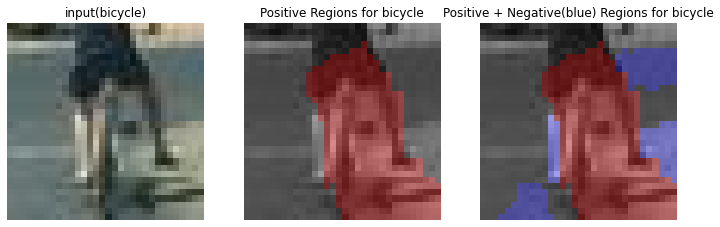

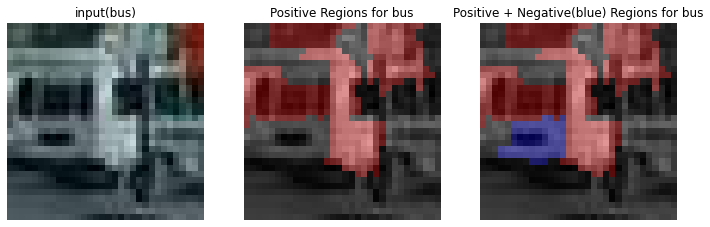

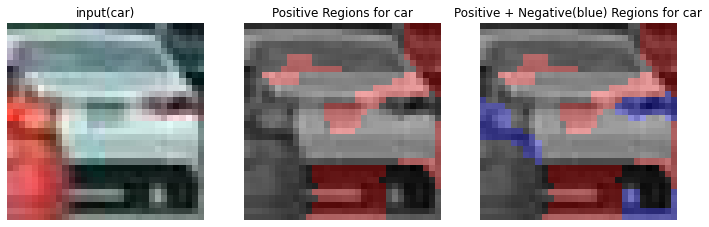

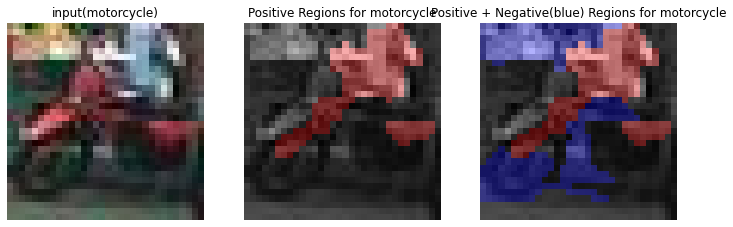

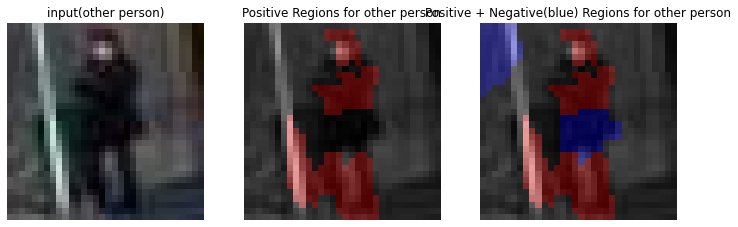

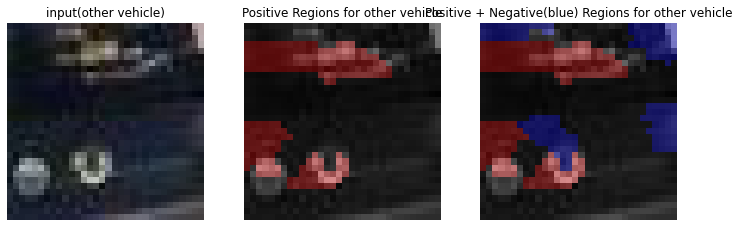

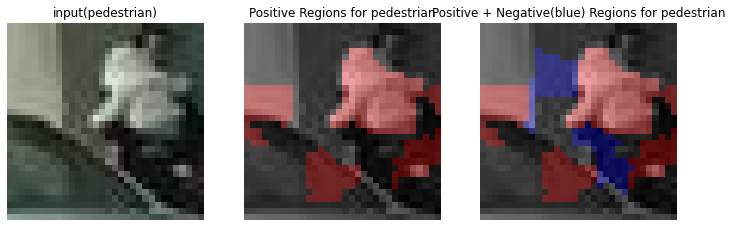

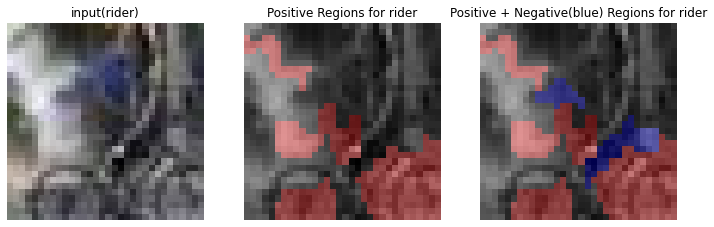

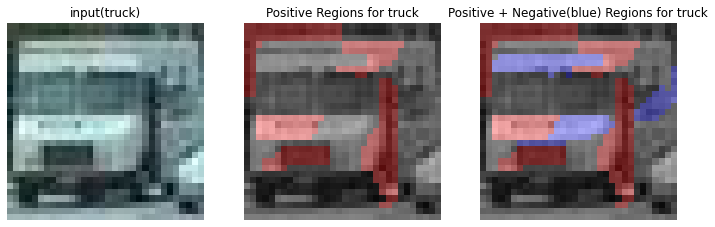

In [33]:
for class_idx,class_name in enumerate(class_names):

    idx=best_index[class_idx]
    ex_images=plt.imread(os.path.join(test_dir, class_name, full_ex_image_file_list[class_idx][idx]))

    ex_image_scaled=np.array(ex_images)
    ex_image_scaled=scaling_x(ex_image_scaled)

    prediction=model.predict(ex_image_scaled.reshape(-1, 32, 32, 3))
    top1_class=prediction.argmax(1)
    top1_prediction=[]
    for i, class_idx in enumerate(top1_class):
        top1_prediction.append(np.round(prediction[i][class_idx], 4))


    exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                  classifier_fn=model.predict,# 9class의 확률 반환 (softmax)
                                  top_labels=2, # 확률 기준 1-5위 분석
                                  num_samples=1000,# 샘플링 공간
                                  segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘
     # 캔버스
    fig, (ax0, ax1, ax2)=plt.subplots(1,3,figsize=(12, 4))
    ax=[ax0, ax1,ax2]
    for i in ax:
        i.grid(False)
    # 예측에 가장 도움되는 세그먼트만 출력

    temp, mask=exp.get_image_and_mask(top1_class[0],
                                     positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    ax0.imshow(ex_images)
    ax0.set_title('input({})'.format(class_name))
    ax0.set_axis_off() 
    # label2rgb : 형광색 마스킹
    ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
    ax1.set_title('Positive Regions for {}'.format(class_name))

    # 모든 세그먼트 출력
    temp, mask=exp.get_image_and_mask(top1_class[0],
                                     positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    # 부정형 제거
    mask*=-1# 색 반전

    mask2=mask.copy()
    mask2[mask2==1]=0

    ax1.imshow(label2rgb(mask2, ex_images, bg_label=0))
    ax1.set_axis_off() 
    ax2.imshow(label2rgb(mask, ex_images, bg_label=0), interpolation='nearest')
    ax2.set_axis_off() 
#     ax2.set_title('Show output image only')
#     ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
    ax2.set_title('Positive + Negative(blue) Regions for {}'.format(class_name))

> LIME은 데이터 하나와 데이터에 대한 분류 확률을 출력하는 모델을 파라미터로 받는다.  
이 외에 서브모듈러 분할 알고리즘을 선정할 수 있다.

In [138]:
# model_regressor를 수정해 설명 모델을 바꿀 수 있고
# segmentation_fn 파라미터를 수정해 이미지분할 알고리즘을 사용할 수 있다.
# 슈퍼픽셀 : 디지털 이미지를 구성하는 점들 중 같은 정보를 가진 점의 집합을 의미한다.

from lime import lime_image # 이미지 모듈
from lime.wrappers.scikit_image import SegmentationAlgorithm # liem이 사용할 수 있게. 

explainer=lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(default), slic, felzenswalb


### hyper : n_segments, compactness, sigma, + Algorithm

In [319]:
index=6

In [210]:
# 이 때 그냥 무작정 잘 맞춘 경우  
positive_ulti=[30, 27, 27, 31, 33, 28, 28, 29, 33]

# 이 때 positive는 정확도 높게 맞췄다는 것이 아닌, top1 <-> top2가 비등한 경우이다.
positive_best=[38, 77, 5, 22, 459, 1, 26, 37, 101]

# 이 때 negative 역시 너무 차이나서는 안 된다. top1 <-> top2가 비등한 경우이다.
negative_best=[13, 40, 18, 44, 481, 17, 13, 39, 27]

In [159]:
from skimage.color import label2rgb # 

### Best

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bicycle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bus


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


motorcycle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other person


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


other vehicle


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pedestrian


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rider


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


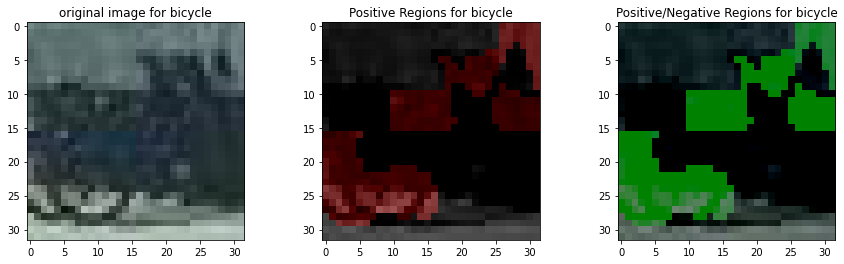

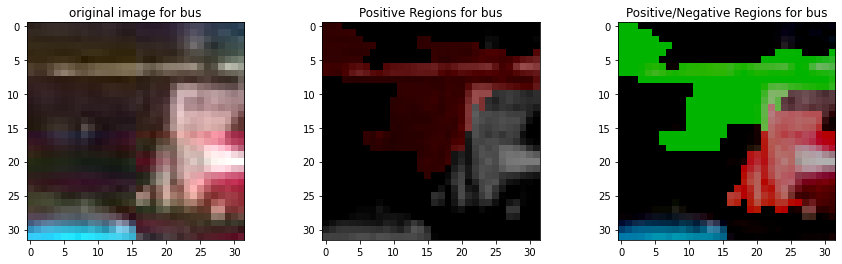

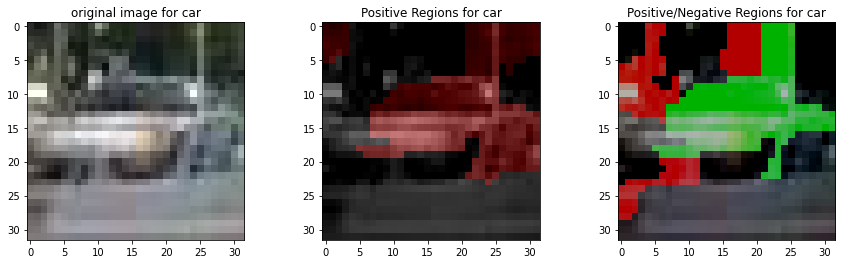

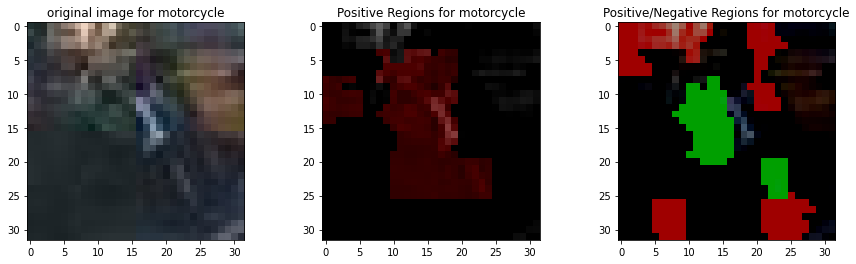

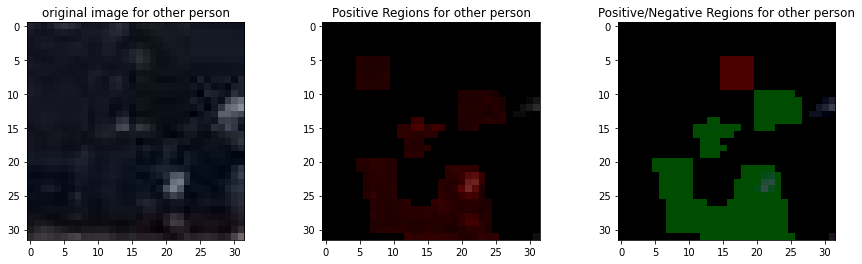

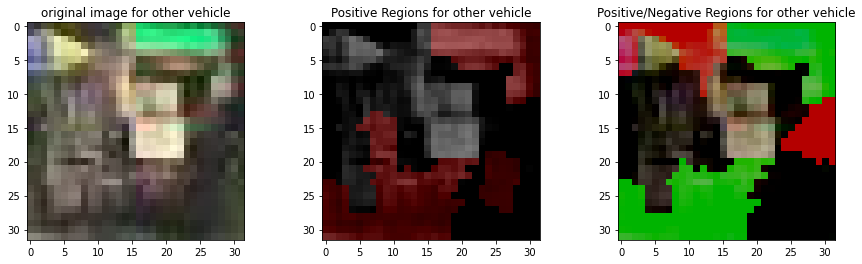

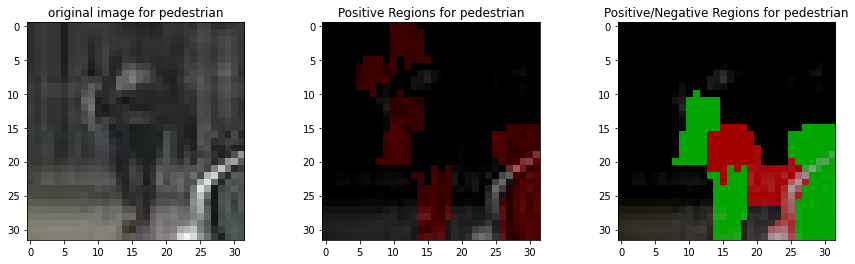

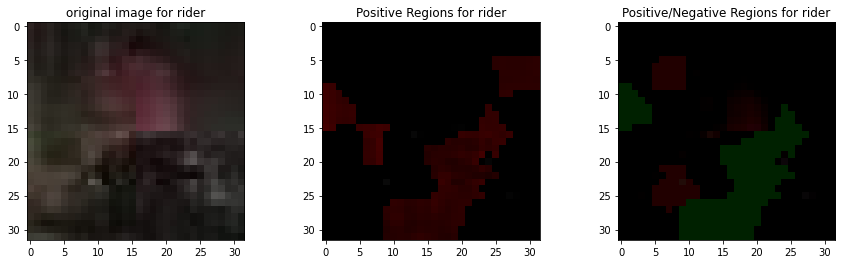

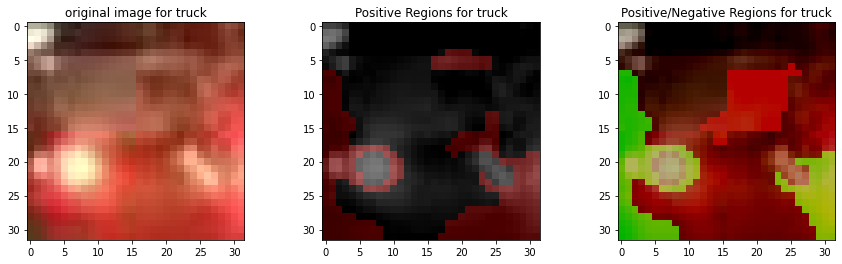

In [244]:
for idx, class_name in enumerate(class_names):    
    
    compact=5
    segments=50
    sigma=0.5
    
    sample_idx=positive_ulti[idx]
    segmenter=SegmentationAlgorithm('slic', 
                                   n_segments=segments, #이미지 분할 조각 개수
                                   compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                                   sigma=sigma) # 스무딩 역할, 0과 1 사이의 float
    
    explainer=lime_image.LimeImageExplainer()
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
    ex_image_scaled=scaling_x(ex_image, x_train_mean)
    
    exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                  classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                                  top_labels=5, # 확률 기준 1-5위 분석
                                   num_samples=1000,# 샘플링 공간
                                  segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

    
    

    # 캔버스
    fig, (ax0, ax1, ax2)=plt.subplots(1,3,figsize=(15,4))
    ax=[ax0, ax1,ax2]s
    for i in ax:
        i.grid(False)
    # 예측에 가장 도움되는 세그먼트만 출력
    print(class_names[idx])
    temp, mask=exp.get_image_and_mask(idx,
                                     positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    ax0.imshow(ex_image)
    ax0.set_title('original image for {}'.format(class_names[idx]))
    # label2rgb : 형광색 마스킹
    ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
    ax1.set_title('Positive Regions for {}'.format(class_names[idx]))

    # 모든 세그먼트 출력
    temp, mask=exp.get_image_and_mask(idx,
                                     positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                     num_features=8, # 분할 영역의 크기
                                     hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
    ax2.imshow(temp, interpolation='nearest')
#     ax2.set_title('Show output image only')
#     ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
    ax2.set_title('Positive/Negative Regions for {}'.format(class_names[idx]))



In [218]:
y_test_num=np.argmax(y_test, axis=-1)

>> 역시 스케일링 한 상태여야 한다.

## Top1 positive, negative

In [223]:
class_names

['bicycle',
 'bus',
 'car',
 'motorcycle',
 'other person',
 'other vehicle',
 'pedestrian',
 'rider',
 'truck']

### Top3 positive

In [247]:
ex_image_scaled.shape

(32, 32, 3)

In [278]:
y_pred[0]

array([7.7466428e-01, 4.6655140e-04, 2.9179394e-06, 4.3836728e-02,
       4.7607422e-02, 3.5550445e-02, 8.8547602e-02, 9.3239350e-03,
       2.3086000e-07], dtype=float32)

### Class 별 Best 찾기

In [ ]:
# for idx, class_name in enumerate(class_names):

class_name=
compact=5
segments=50
sigma=0.5

sample_idx=positive_best[idx]
segmenter=SegmentationAlgorithm('slic', 
                               n_segments=segments, #이미지 분할 조각 개수
                               compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                               sigma=sigma) # 스무딩 역할, 0과 1 사이의 float

explainer=lime_image.LimeImageExplainer()
ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
ex_image_scaled=scaling_x(ex_image, x_train_mean)
y_pred=model.predict(ex_image_scaled.reshape(-1, 32, 32, 3))
exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=3, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘


fig,m_axs=plt.subplots(2,3, figsize=(12,6))


first=1
for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):

    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001) 
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    print(i)
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(class_names[i],
                                                           100*y_pred[0][i]))
    c_ax.axis('off')


    ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_ulti[i]]
    ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
    if first==1:
        ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_best[i]]
        ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
    gt_ax.imshow(ref_image)


    gt_ax.set_title('Example of {}'.format(class_names[i]))
    gt_ax.axis('off')



/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
6
4


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
8
2


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
5
1


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
3
6


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
3
0


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
8
1


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
7
3


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
6
3


/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jrkim/.conda/envs/jsp/lib/python3.6/site-packages/skimage/color/colorlabel.py:114: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
1
5


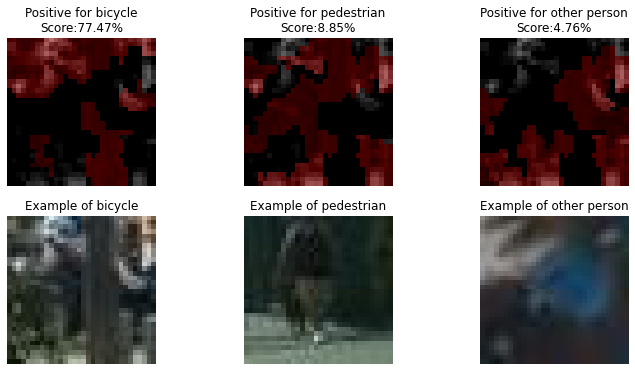

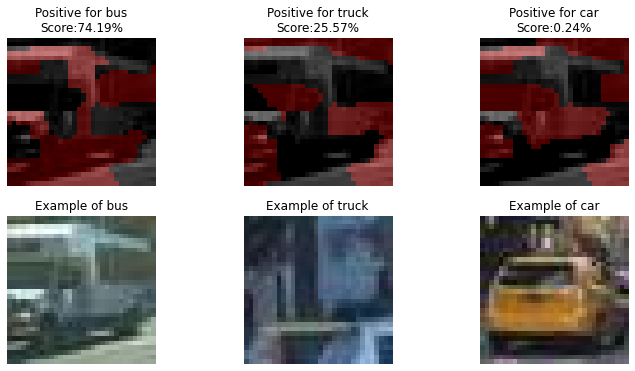

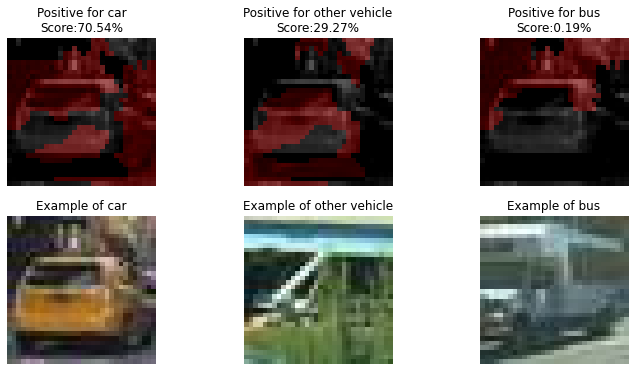

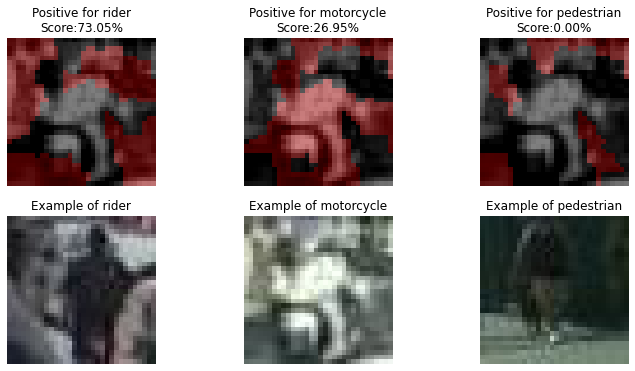

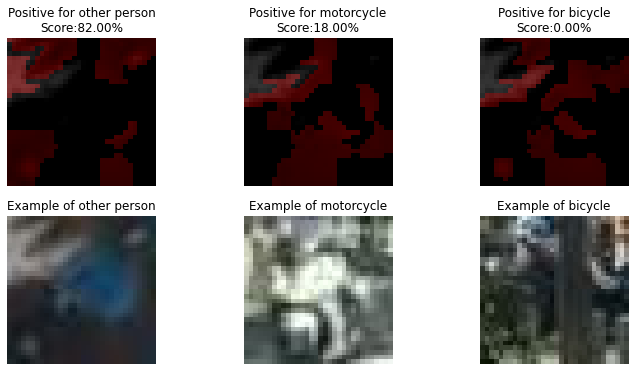

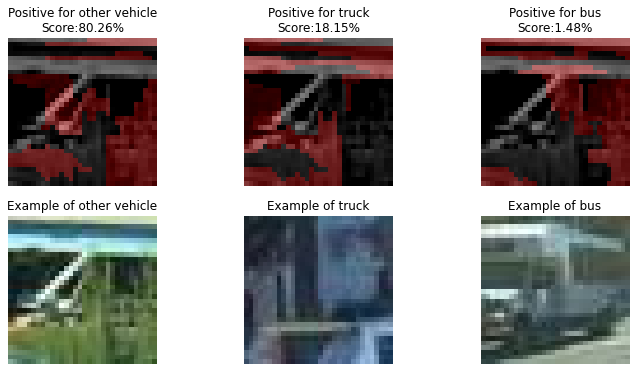

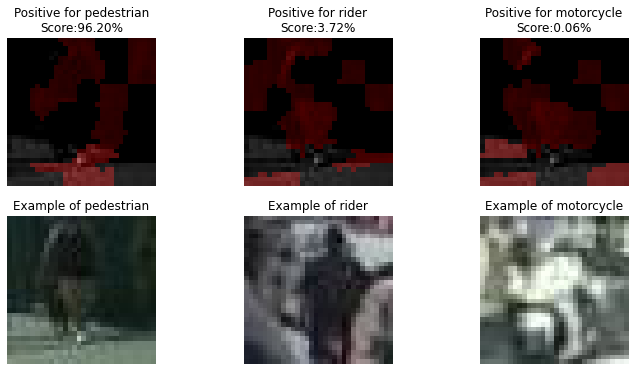

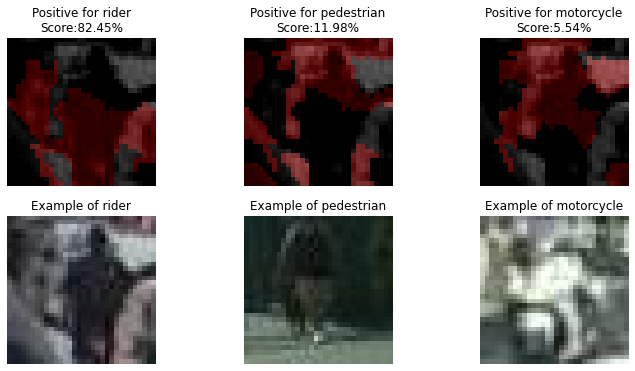

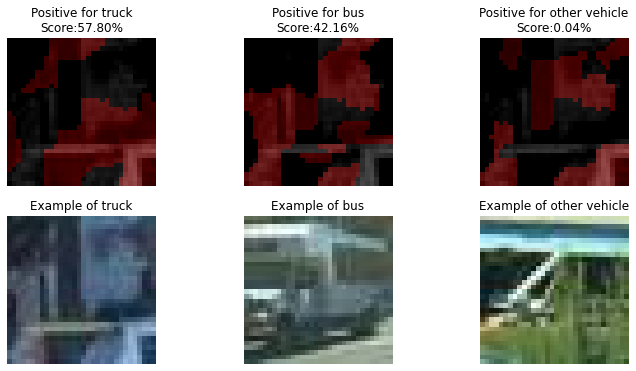

In [283]:
for idx, class_name in enumerate(class_names):
   
    compact=5
    segments=50
    sigma=0.5
    
    sample_idx=positive_best[idx]
    segmenter=SegmentationAlgorithm('slic', 
                                   n_segments=segments, #이미지 분할 조각 개수
                                   compactness=compact, # 유사한 파트를 합치는 함수, log scale, default : 10
                                   sigma=sigma) # 스무딩 역할, 0과 1 사이의 float
    
    explainer=lime_image.LimeImageExplainer()
    ex_image_file=os.listdir(os.path.join(test_dir, class_name))[sample_idx]
    ex_image=plt.imread(os.path.join(test_dir, class_name, ex_image_file))
    ex_image_scaled=scaling_x(ex_image, x_train_mean)
    y_pred=model.predict(ex_image_scaled.reshape(-1, 32, 32, 3))
    exp=explainer.explain_instance(ex_image_scaled, #데이터 하나
                                  classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                                  top_labels=3, # 확률 기준 1-5위 분석
                                   num_samples=1000,# 샘플링 공간
                                  segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

    
    fig,m_axs=plt.subplots(2,3, figsize=(12,6))

    
    first=1
    for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
        
        temp, mask=exp.get_image_and_mask(i,
                                             positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                             num_features=12, # 분할 영역의 크기
                                             hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                             min_weight=0.001) 
        c_ax.imshow(label2rgb(mask, temp, bg_label=0),
                   interpolation='nearest')
        print(i)
        c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(class_names[i],
                                                               100*y_pred[0][i]))
        c_ax.axis('off')
        
        
        ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_ulti[i]]
        ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
        if first==1:
            ref_image_file=os.listdir(os.path.join(test_dir, class_names[i]))[positive_best[i]]
            ref_image=plt.imread(os.path.join(test_dir, class_names[i], ref_image_file))
        gt_ax.imshow(ref_image)
        
        
        gt_ax.set_title('Example of {}'.format(class_names[i]))
        gt_ax.axis('off')

